# Classical Link Prediction
In this notebook we will show how to run, starting from the embeddings previously obtained, a classical link prediction with experimental setup as close as possible to Leskovec et al and Yue et al.

In [1]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

## Retrieving the embeddings
We will run the link prediction for each one of the embedding that we have previously obtained:

- CBOW
- SkipGram
- BinarySkipGram
- GloVe


## Edge embeddings
We will compute the edge embeddings using all the 5 available methods:

- Hadamart: an element-wise product
- Mean
- Norm L1
- Norm L2
- Concatenation

## Defining a simple Feed Forward Neural Network

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC, Recall, Precision

def build_link_prediction_model(input_shape:int):
    model = Sequential([
        Input(input_shape),
        Dense(256, activation="relu"),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=[
            AUC(curve="PR", name="auprc"),
            AUC(curve="ROC", name="auroc"),
            Recall(),
            Precision(),
            "accuracy"
        ]
    )
    return model

## Loading the graph
As done previously, we are going to load the graph.

In [3]:
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_csv(
    edge_path="../data/ppi/edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
)

## Defining holdouts and tasks data generator
We are going to create the same edge embeddings as in the training of the embeddings.

In [4]:
seed = 42
train_percentage = 0.8

pos_training, pos_validation = graph.connected_holdout(seed=seed, train_percentage=train_percentage)
neg_training, neg_validation = graph.sample_negatives(
    seed=seed,
    negatives_number=graph.get_edges_number(),
    allow_selfloops=False
).random_holdout(seed=seed, train_percentage=train_percentage)

In [5]:
from tqdm.auto import tqdm
from glob import glob
from embiggen import GraphTransformer, EdgeTransformer
import numpy as np


def task_generator(
    pos_training:EnsmallenGraph,
    pos_validation:EnsmallenGraph,
    neg_training:EnsmallenGraph,
    neg_validation:EnsmallenGraph,
    train_percentage:float=0.8,
    seed:int=42
):
    """Create new generator of tasks.
    
    Parameters
    ----------------------------------
    pos_training:EnsmallenGraph,
        The positive edges of the training graph.
    pos_validation:EnsmallenGraph,
        The positive edges of the validation graph.
    neg_training:EnsmallenGraph,
        The negative edges of the training graph.
    neg_validation:EnsmallenGraph,
        The negative edges of the validation graph.
    train_percentage:float=0.8,
    seed:int=42
    
    """
    for path in tqdm(glob("*embedding.npy"), desc="Embedding"):
        model_name = path.split("_")[0]
        embedding = np.load(path)
        for method in tqdm(EdgeTransformer.methods, desc="Methods", leave=False):
            transformer = GraphTransformer(method)
            transformer.fit(embedding)
            train_edges = np.vstack([
                transformer.transform(graph)
                for graph in (pos_training, neg_training)
            ])
            valid_edges = np.vstack([
                transformer.transform(graph)
                for graph in (pos_validation, neg_validation)
            ])
            train_labels = np.concatenate([
                np.ones(pos_training.get_edges_number()),
                np.zeros(neg_training.get_edges_number())
            ])
            valid_labels = np.concatenate([
                np.ones(pos_validation.get_edges_number()),
                np.zeros(neg_validation.get_edges_number())
            ])
            train_indices = np.arange(0, train_labels.size)
            valid_indices = np.arange(0, valid_labels.size)
            np.random.shuffle(train_indices)
            np.random.shuffle(valid_indices)
            train_edges = train_edges[train_indices]
            train_labels = train_labels[train_indices]
            valid_edges = valid_edges[valid_indices]
            valid_labels = valid_labels[valid_indices]
            yield model_name, method, (train_edges, train_labels), (valid_edges, valid_labels)

## Training the models

In [6]:
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import pandas as pd

histories = {}
strategy = MirroredStrategy()
os.makedirs("classical_link_prediction", exist_ok=True)

for embedding_model, method, train, valid in task_generator(pos_training, pos_validation, neg_training, neg_validation):
    history_path = f"classical_link_prediction/{embedding_model}_{method}.csv"
    if os.path.exists(history_path):
        histories[(embedding_model, method)] = pd.read_csv(history_path)
        continue
    with strategy.scope():
        model = build_link_prediction_model(train[0].shape[1:])
    history = pd.DataFrame(model.fit(
        *train,
        batch_size=2**12,
        validation_data=valid,
        epochs=1000,
        callbacks=[
            EarlyStopping("val_loss", patience=20, min_delta=0.0001),
            ReduceLROnPlateau()
        ]
    ).history)

    history.to_csv(history_path, index=False)
    histories[(embedding_model, method)] = history
    

## Plotting all the computer histories

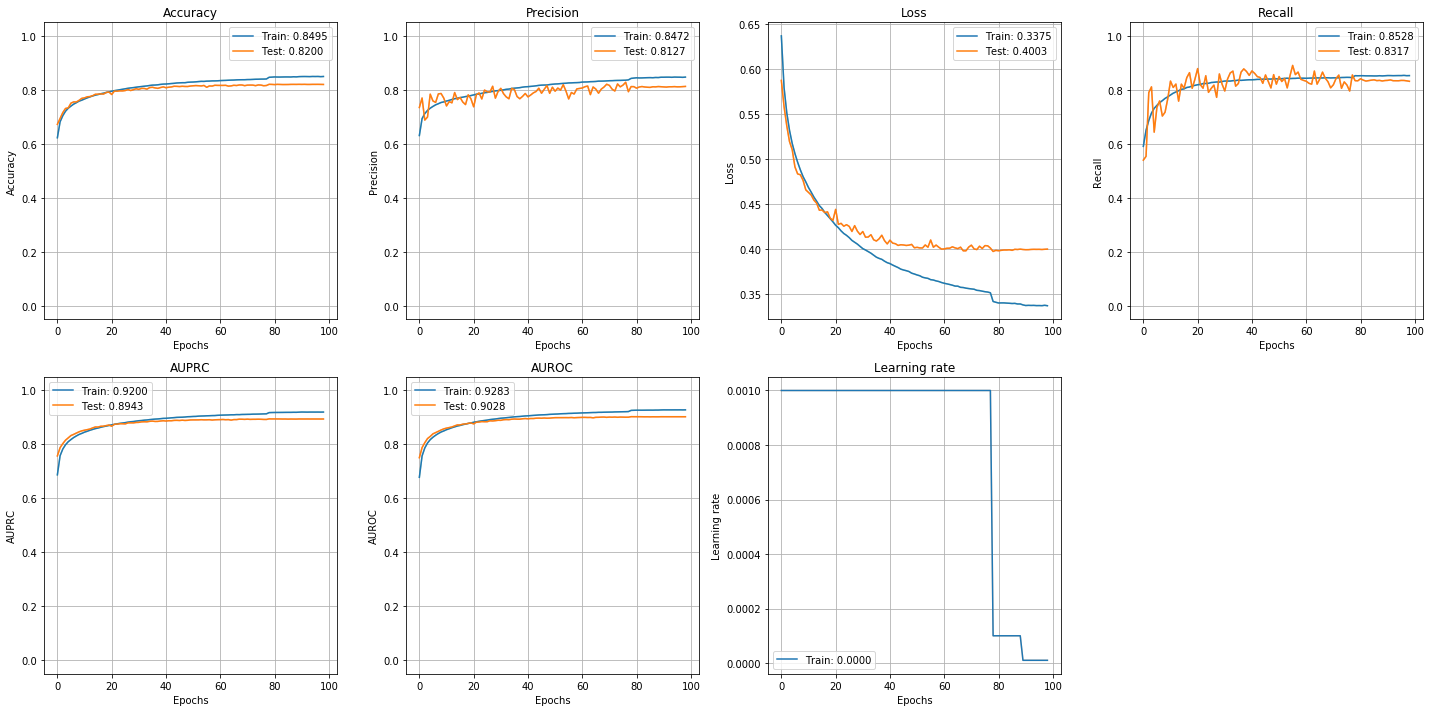

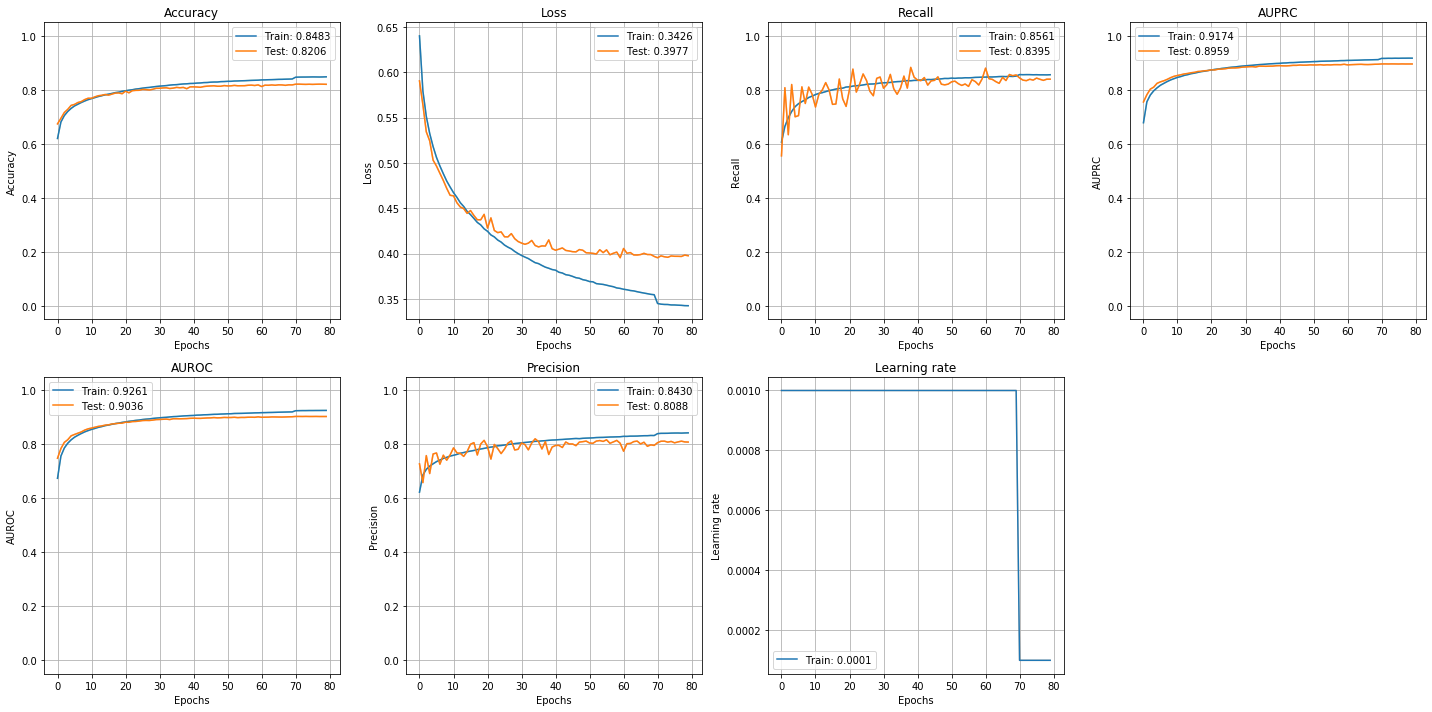

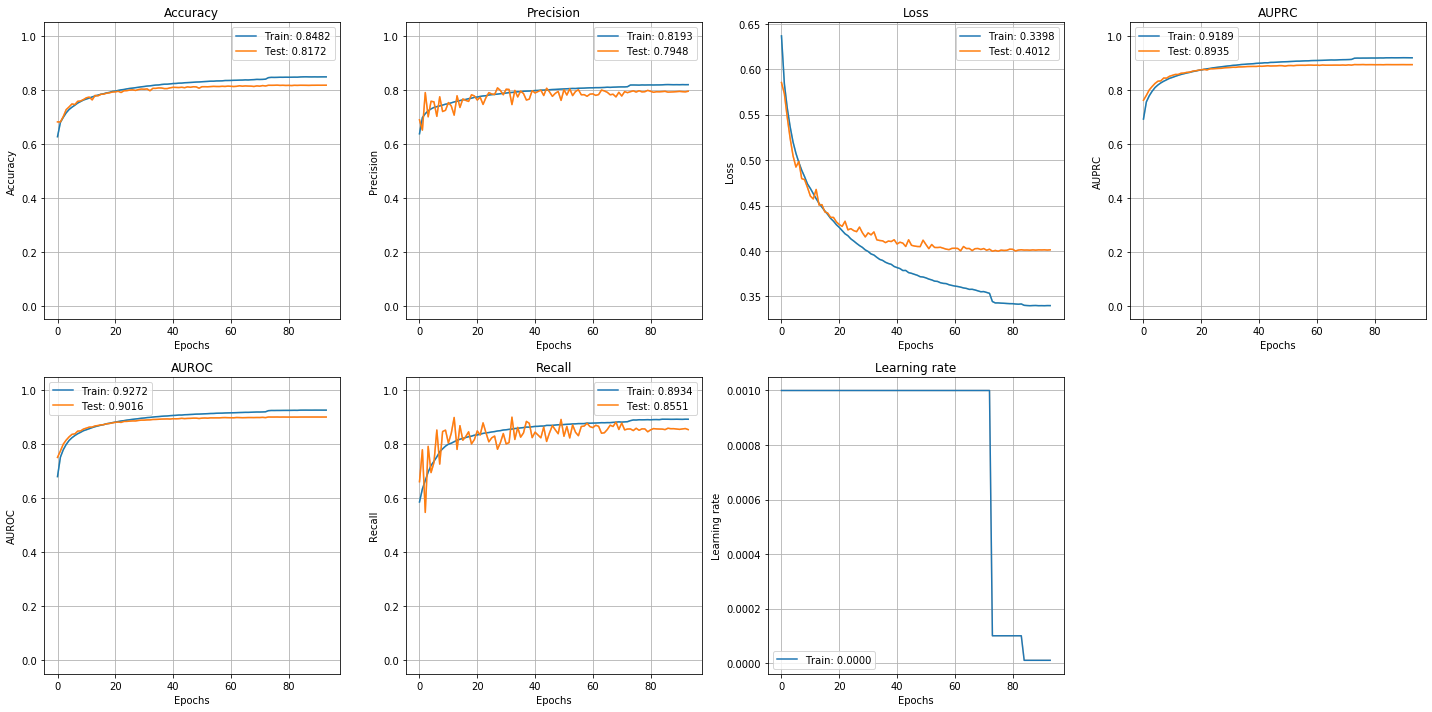

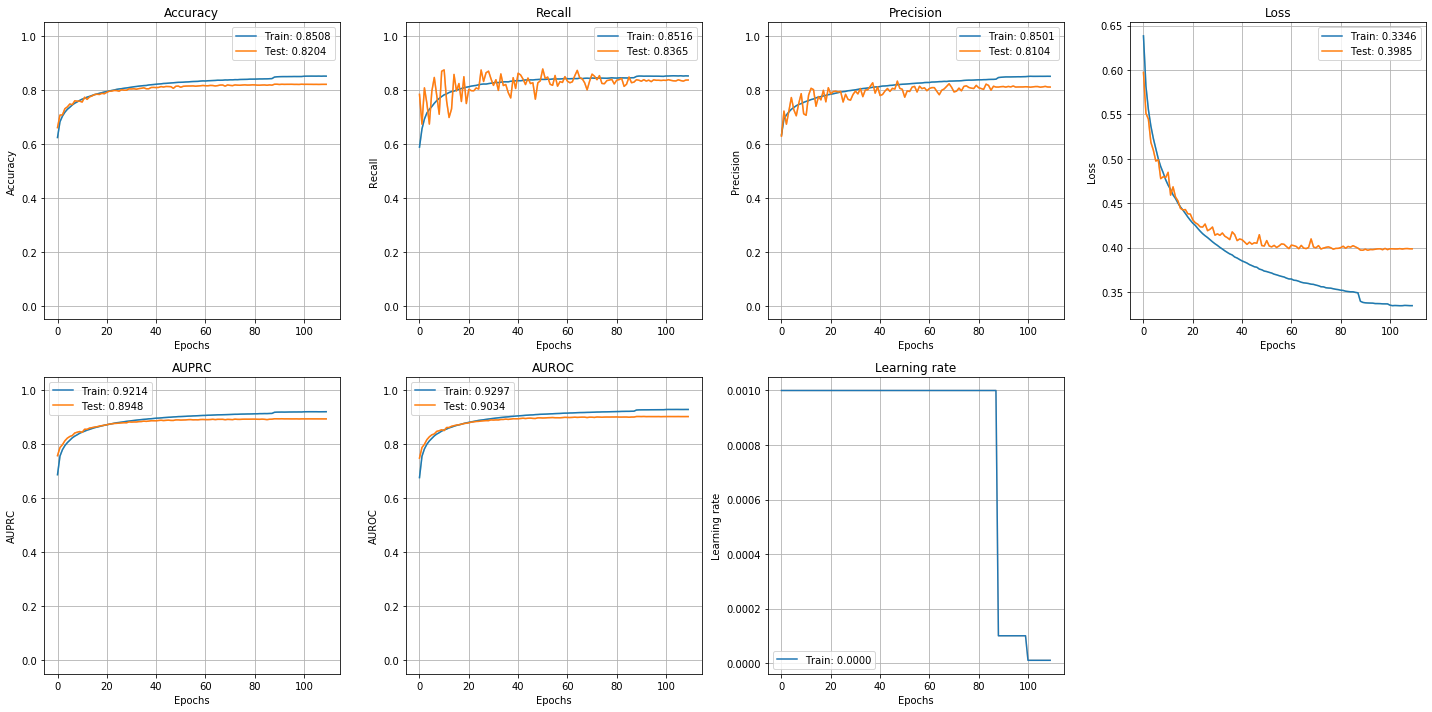

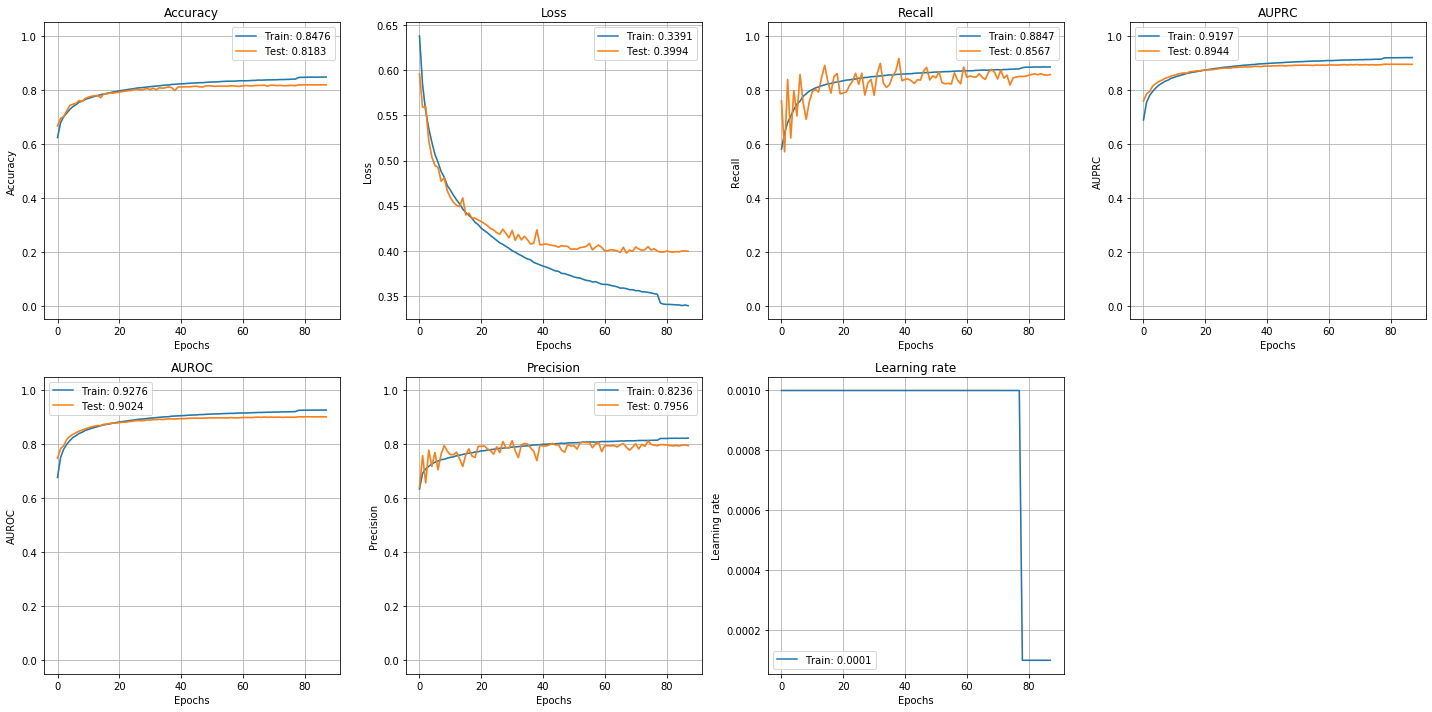

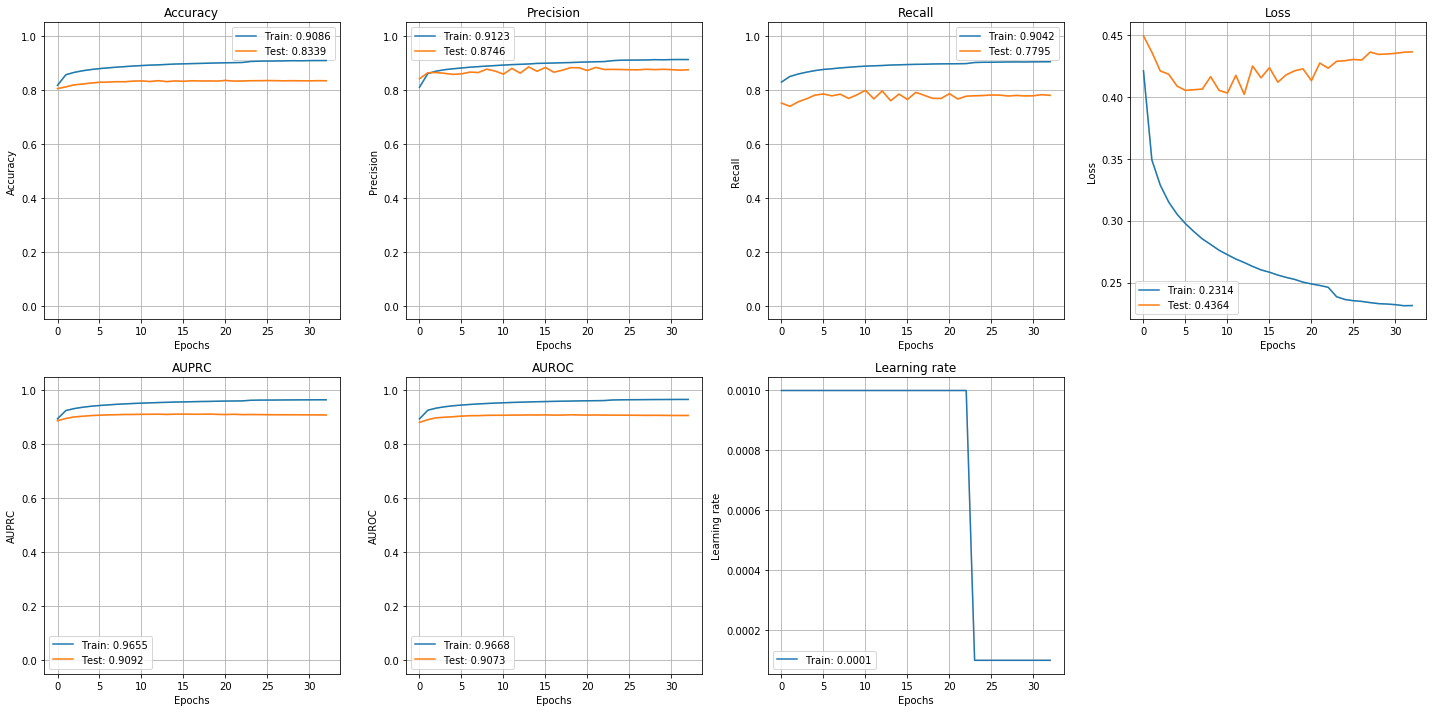

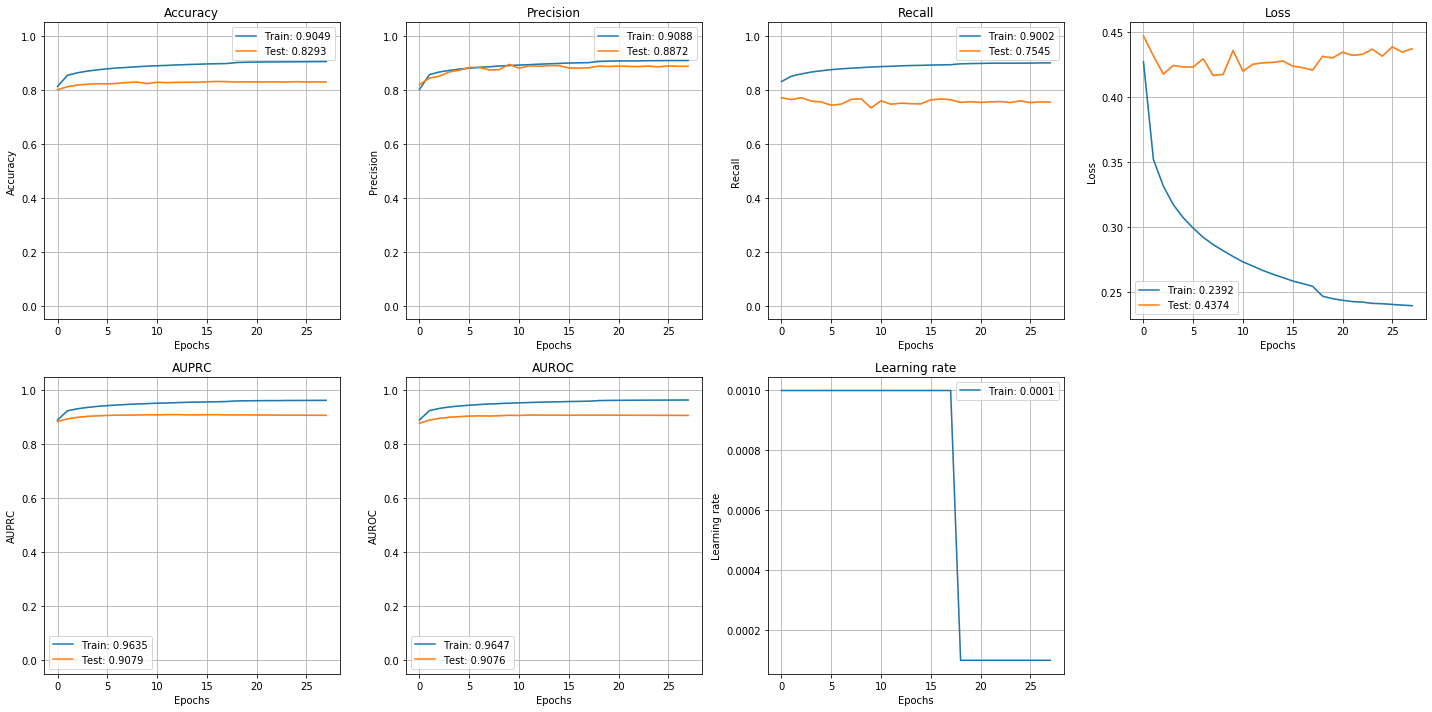

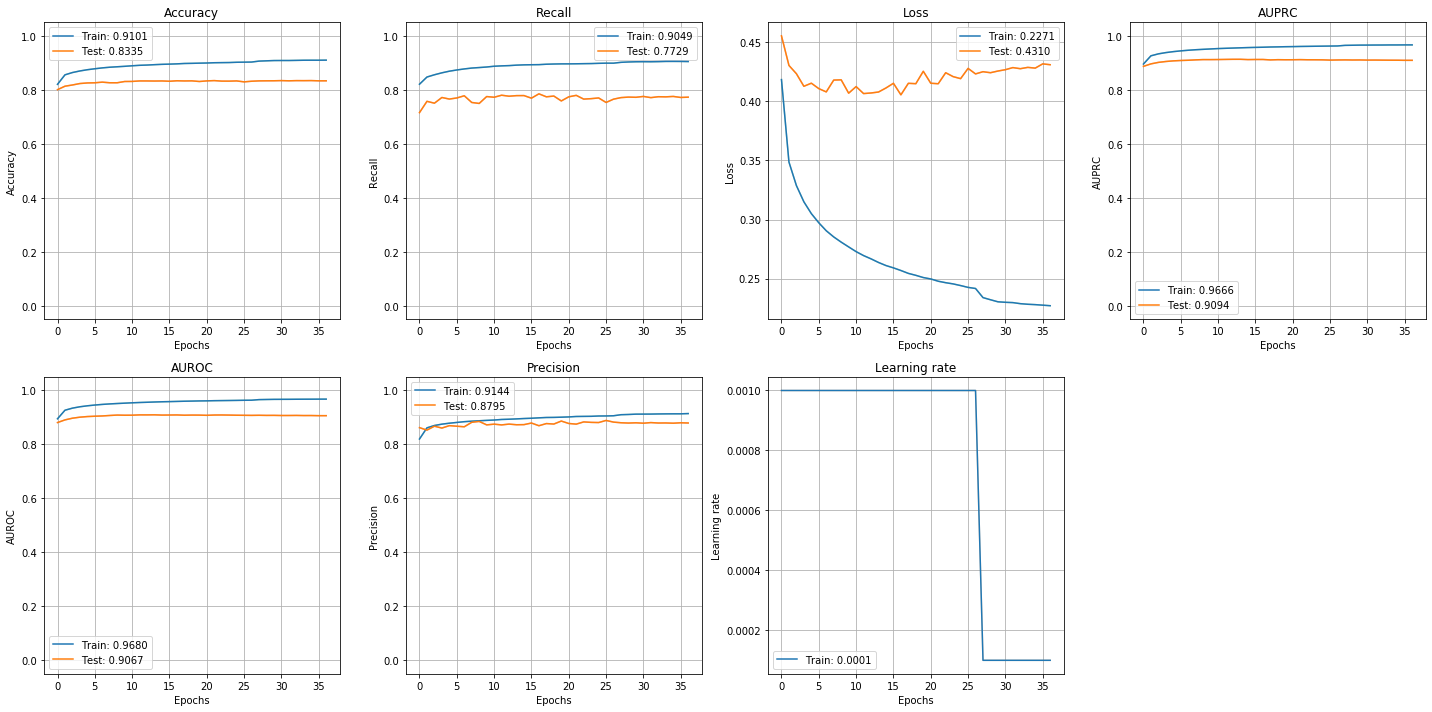

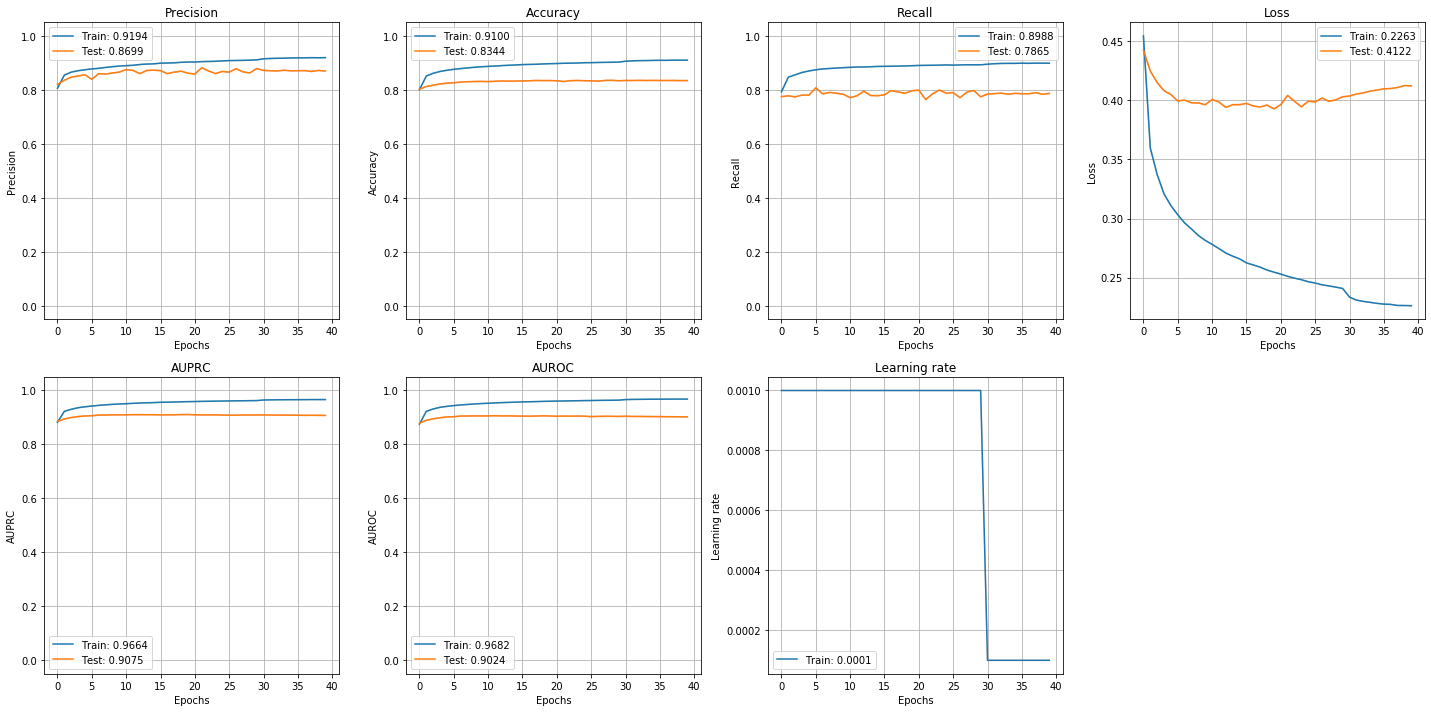

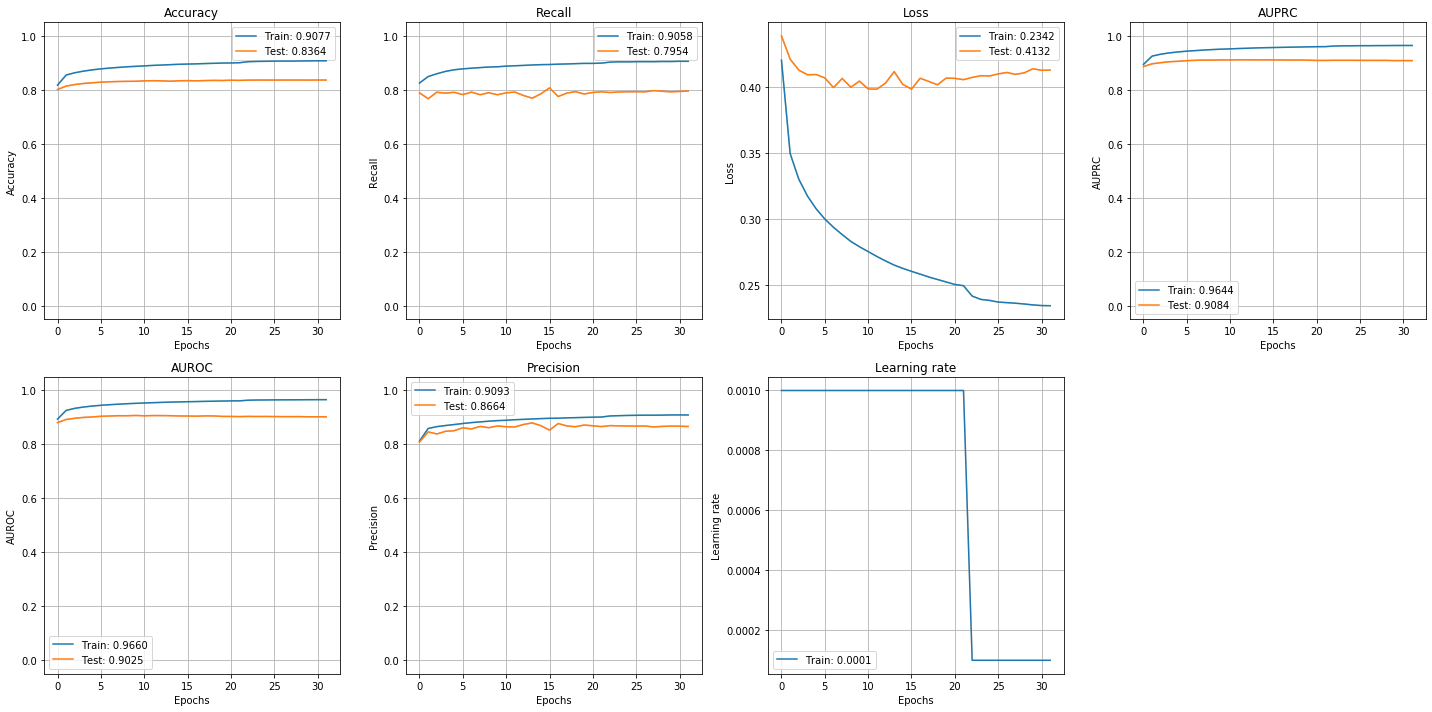

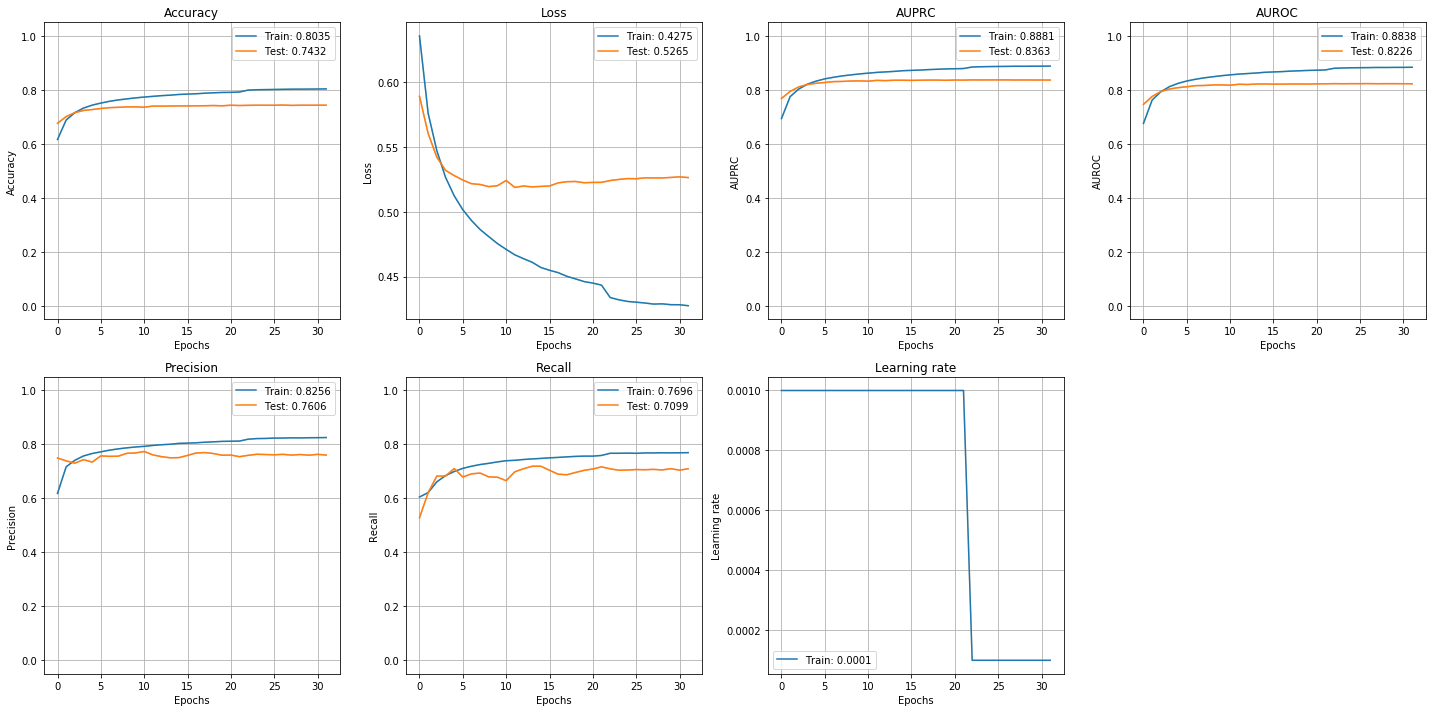

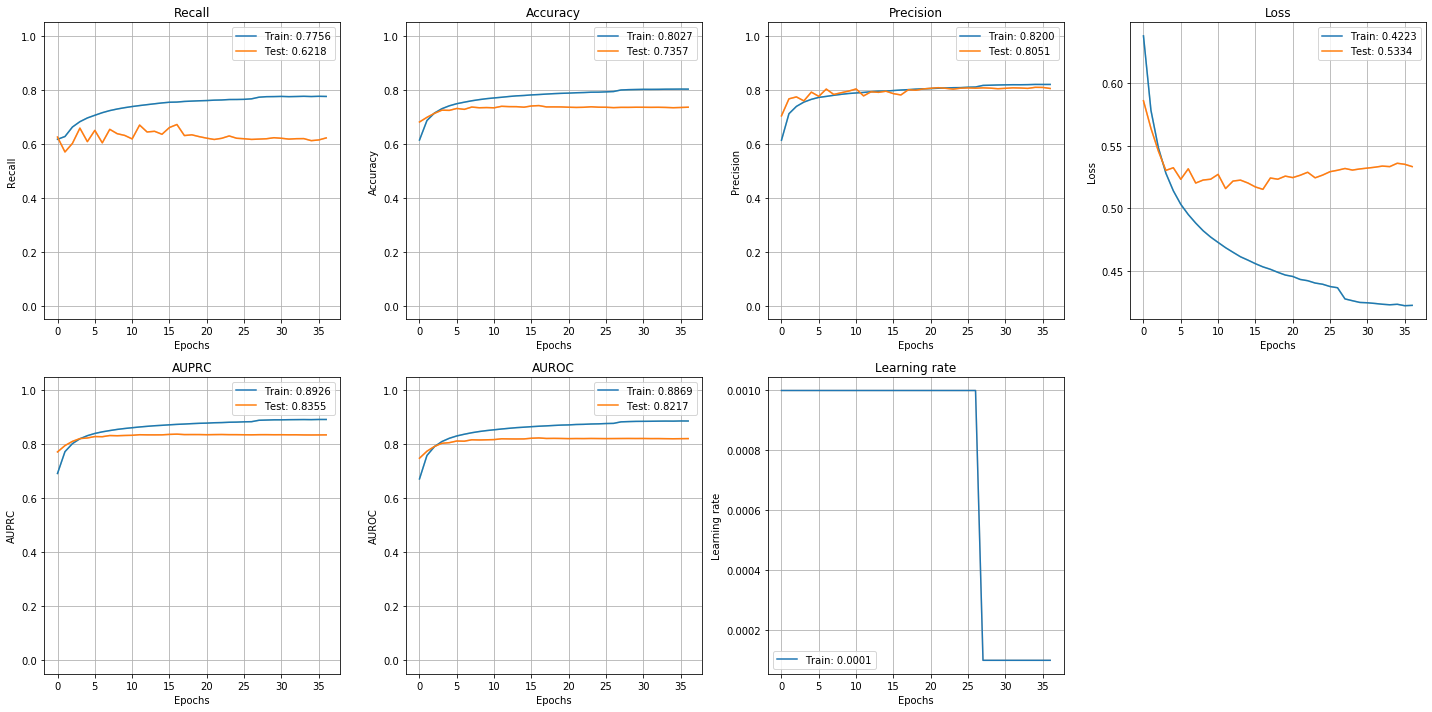

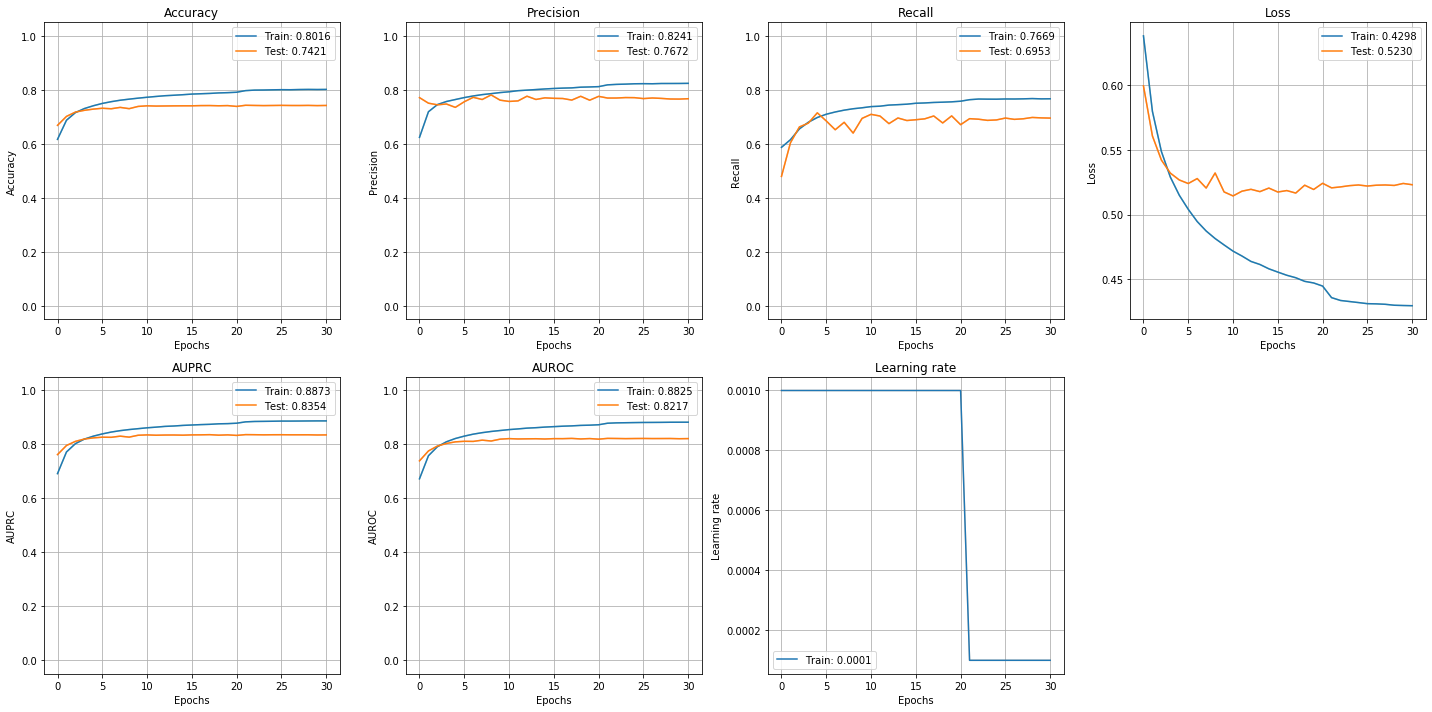

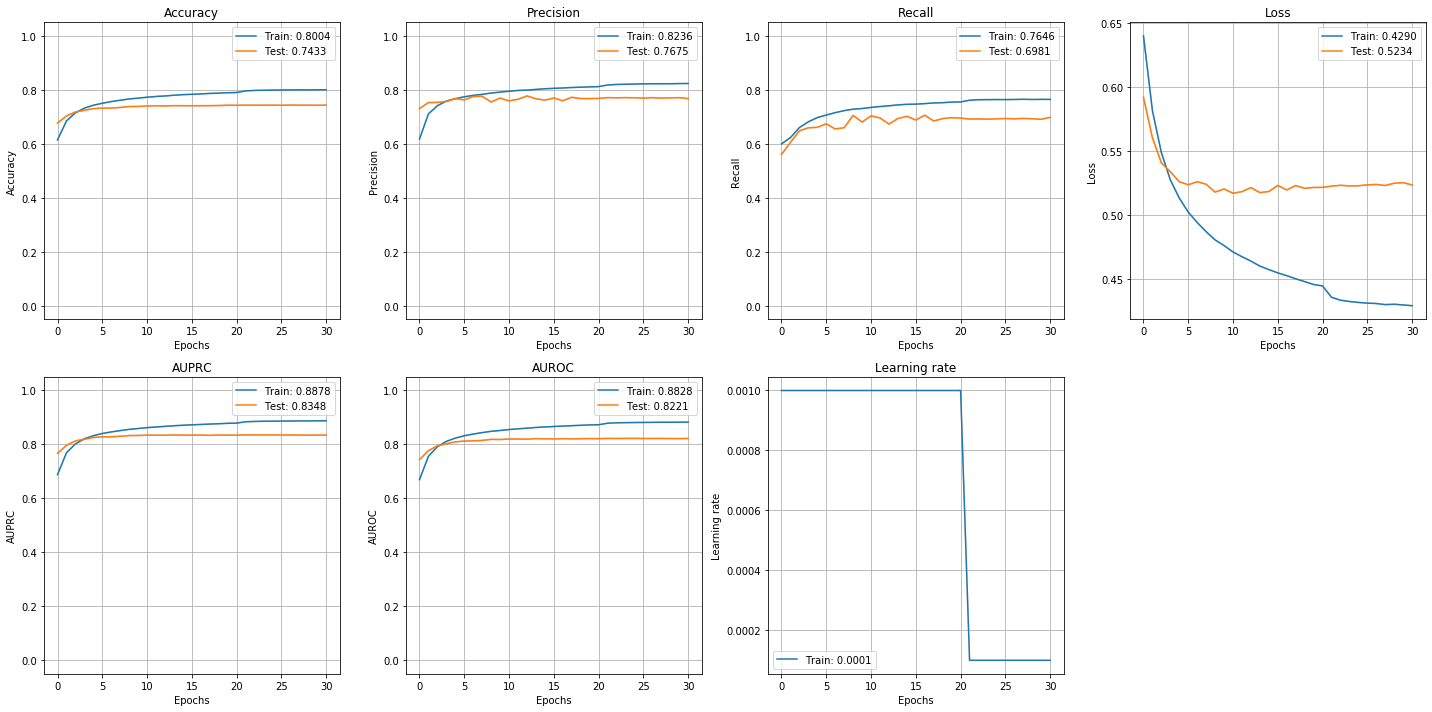

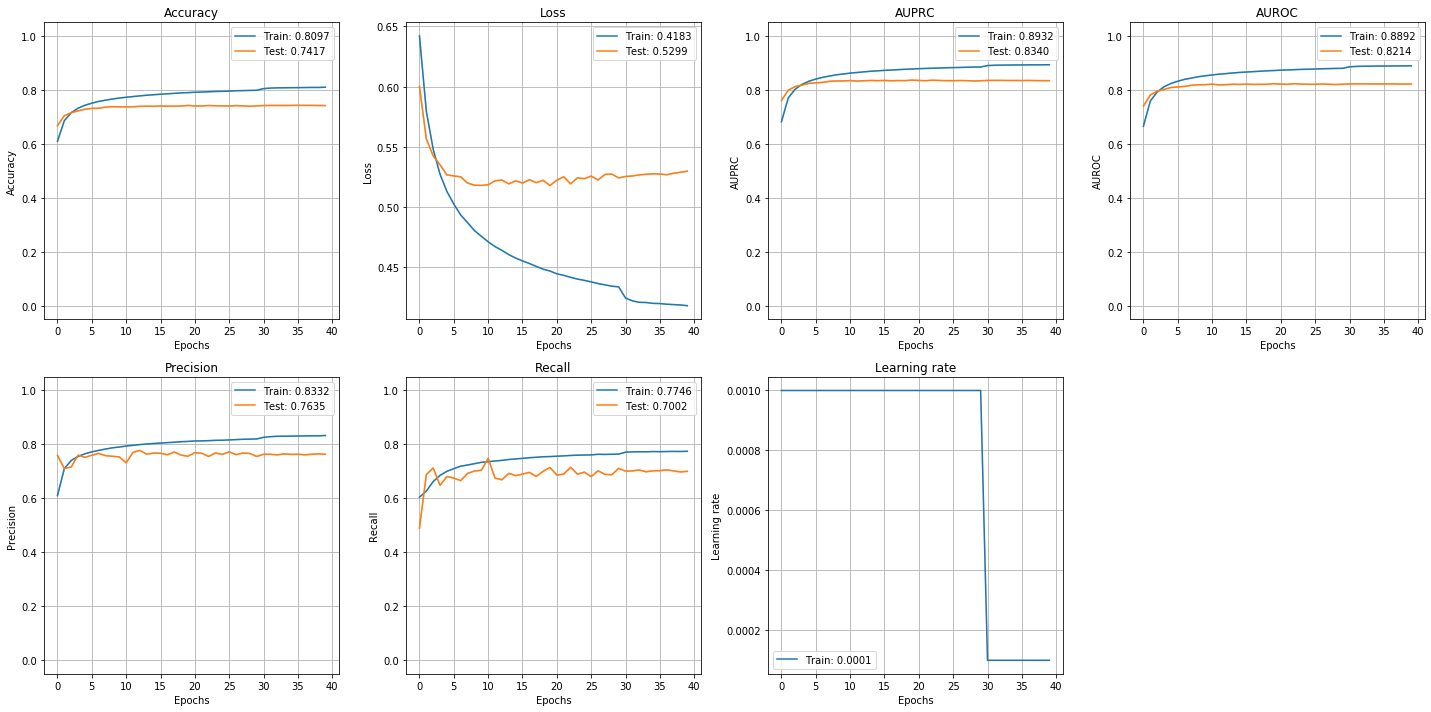

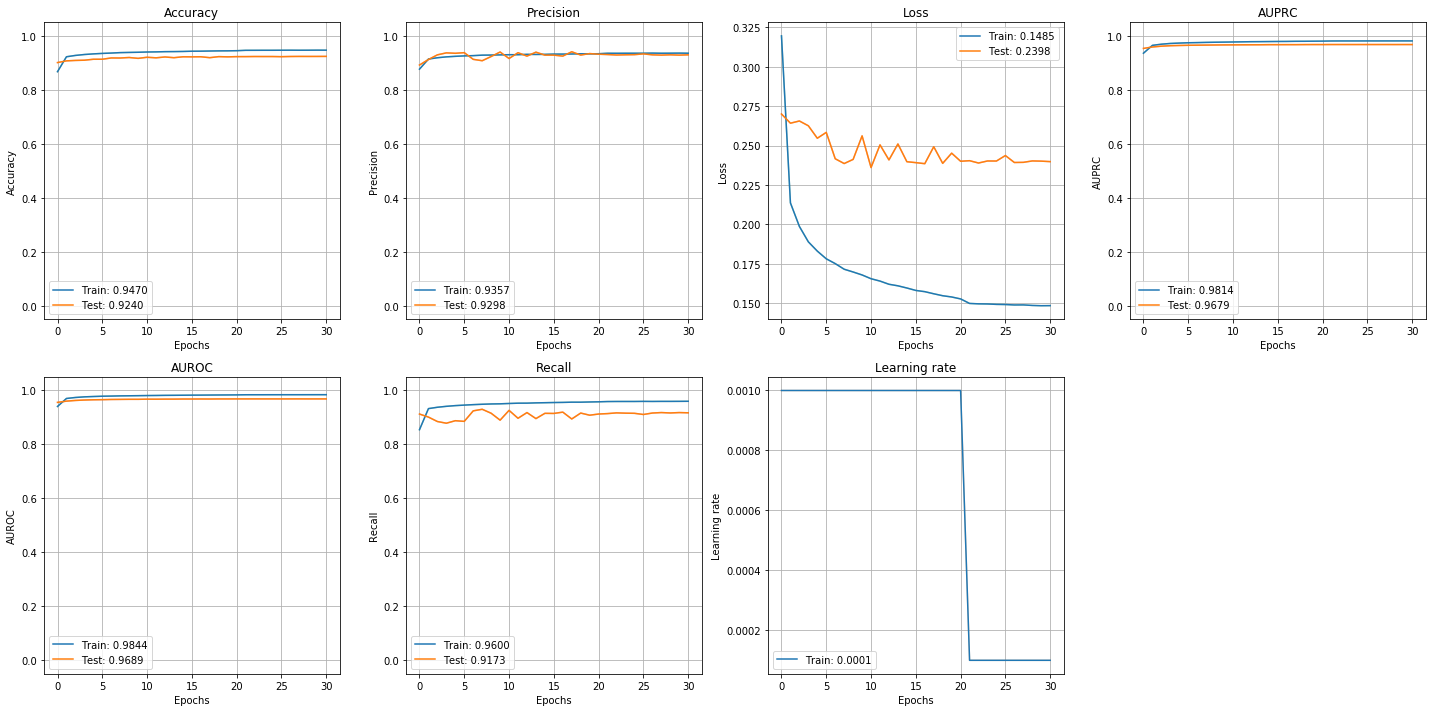

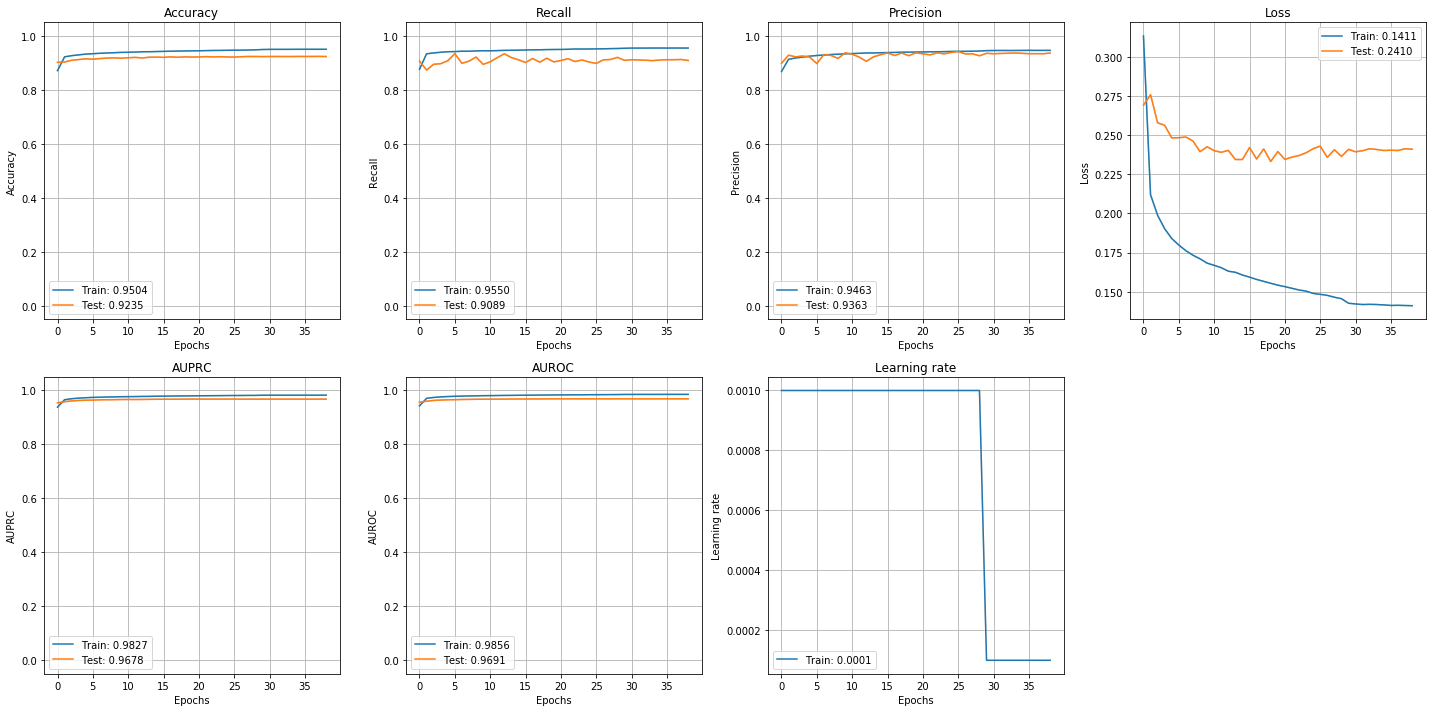

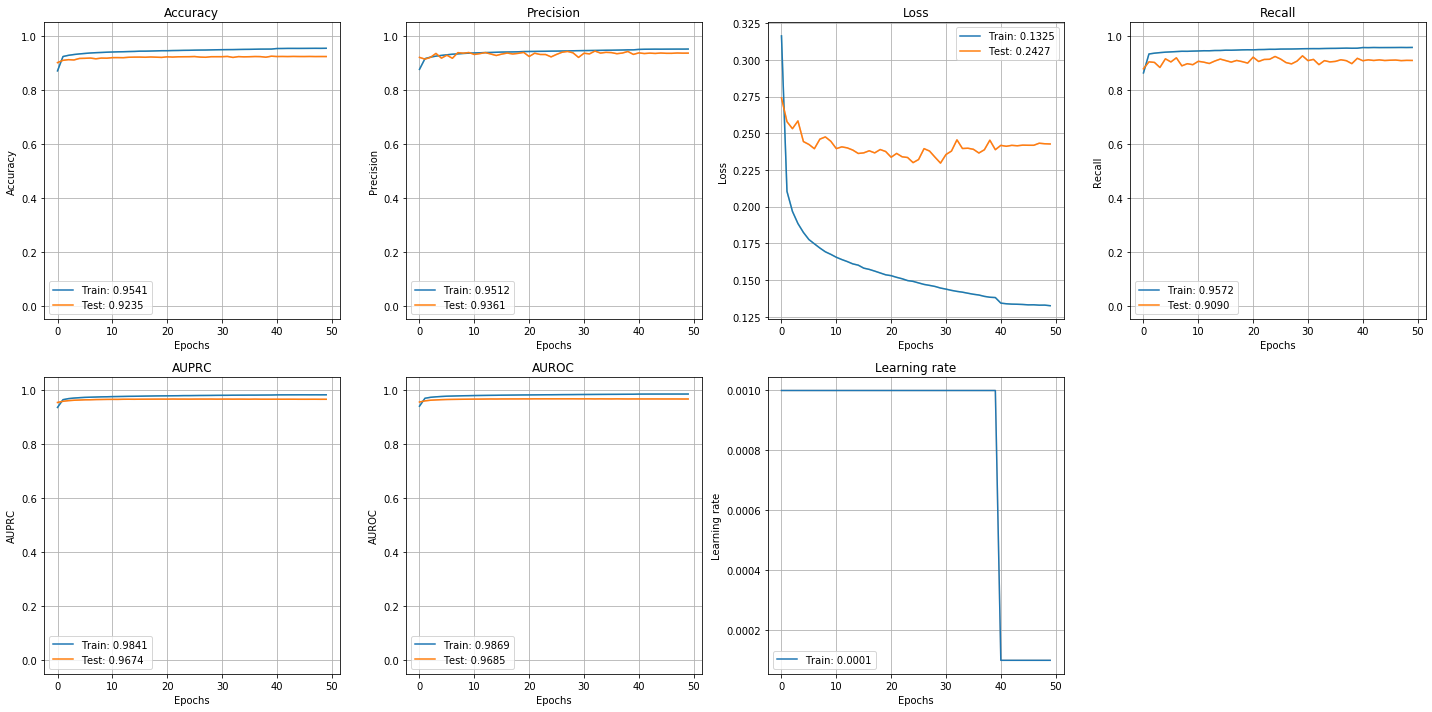

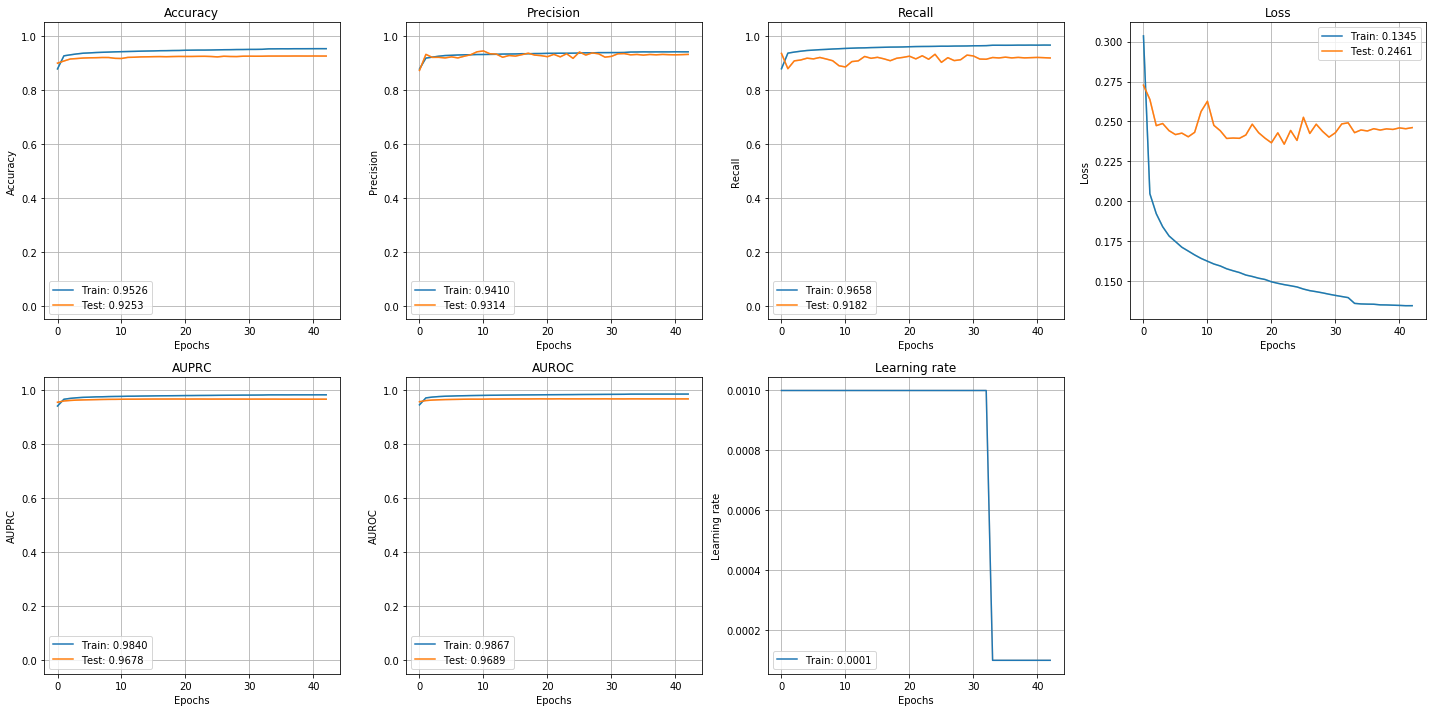

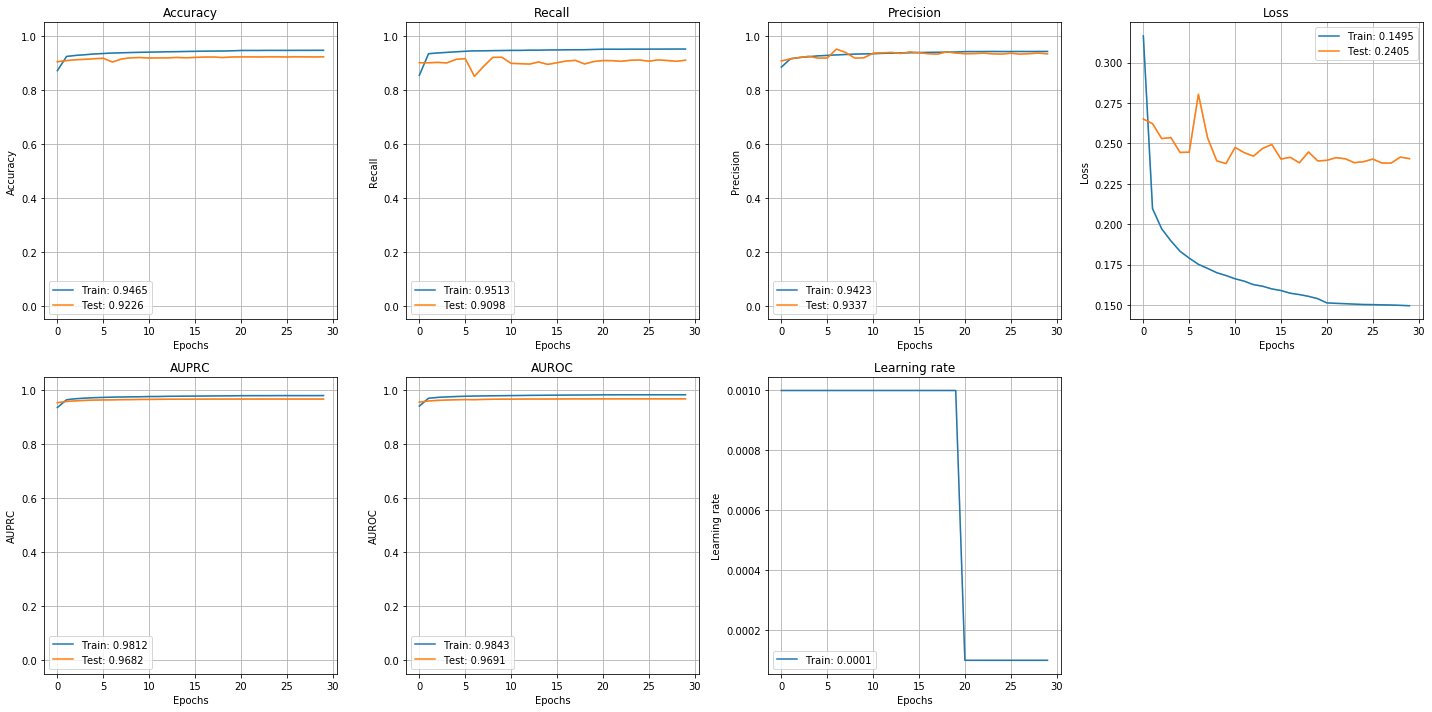

In [7]:
from plot_keras_history import plot_history

for history in histories.values():
    plot_history(history)

## Displaying results of various embedding methods

First we covert the histories into an homogeneous report:

In [51]:
from sanitize_ml_labels import sanitize_ml_labels

report = []
for (model, method), history in histories.items():
    last_epoch = history.iloc[-1].to_dict()
    sanitize = {
        sanitize_ml_labels(label):value
        for label, value in last_epoch.items()
        if label not in ("lr")
    }
    training = {
        key:val
        for key, val in sanitize.items()
        if "Val" not in key
    }
    validation = {
        sanitize_ml_labels(key.replace("Val ", "")):val
        for key, val in sanitize.items()
        if "Val" in key
    }
    
    report.append({
        "run":"training",
        "embedding_model":model,
        "model":"MLP",
        "method":method,
        **training
    })
    report.append({
        "run":"validation",
        "embedding_model":model,
        "model":"MLP",
        "method":method,
        **validation
    })

report = pd.DataFrame(report)

## Training link prediction on some other models
Here we execute the link prediction using Random Forests, Decision Trees and Logistic Regression so to have a good comparison.

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import cpu_count

kwargs = {
    "DecisionTreeClassifier":dict(
        max_depth=50,
        random_state=42
    ),
    "RandomForestClassifier":dict(
        n_estimators=500,
        max_depth=50,
        n_jobs=cpu_count(),
        random_state=42
    ),
    "LogisticRegression":dict(
        random_state=42
    )
}

def metric_report(y_true, y_pred):
    metrics = (
        roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
    )
    return {
        sanitize_ml_labels(metric.__name__):metric(y_true, y_pred)
        for metric in metrics
    }

metrics_reports_path = "classical_link_prediction/linear_models_reports.csv"
if os.path.exists(metrics_reports_path):
    metrics_reports = pd.read_csv(metrics_reports_path)
else:
    metrics_reports = []

    for embedding_model, method, train, valid in task_generator(pos_training, pos_validation, neg_training, neg_validation):
        for model_builder in tqdm((DecisionTreeClassifier, RandomForestClassifier, LogisticRegression), desc="Model", leave=False):
            model = model_builder(**kwargs[model_builder.__name__])
            train_x, train_y = train
            valid_x, valid_y = valid
            model.fit(train_x, train_y)
            train_y_pred = model.predict(train_x)
            valid_y_pred = model.predict(valid_x)
            metrics_reports.append({
                "run":"training",
                "embedding_model":embedding_model,
                "model":model_builder.__name__,
                "method":method,
                **metric_report(train_y, train_y_pred)
            })
            metrics_reports.append({
                "run":"validation",
                "embedding_model":embedding_model,
                "model":model_builder.__name__,
                "method":method,
                **metric_report(valid_y, valid_y_pred)
            })

    metrics_reports = pd.DataFrame(metrics_reports)
    metrics_reports.to_csv(metrics_reports_path, index=None)
    

## Merging reports

In [52]:
all_reports = pd.concat([
    metrics_reports,
    report
])

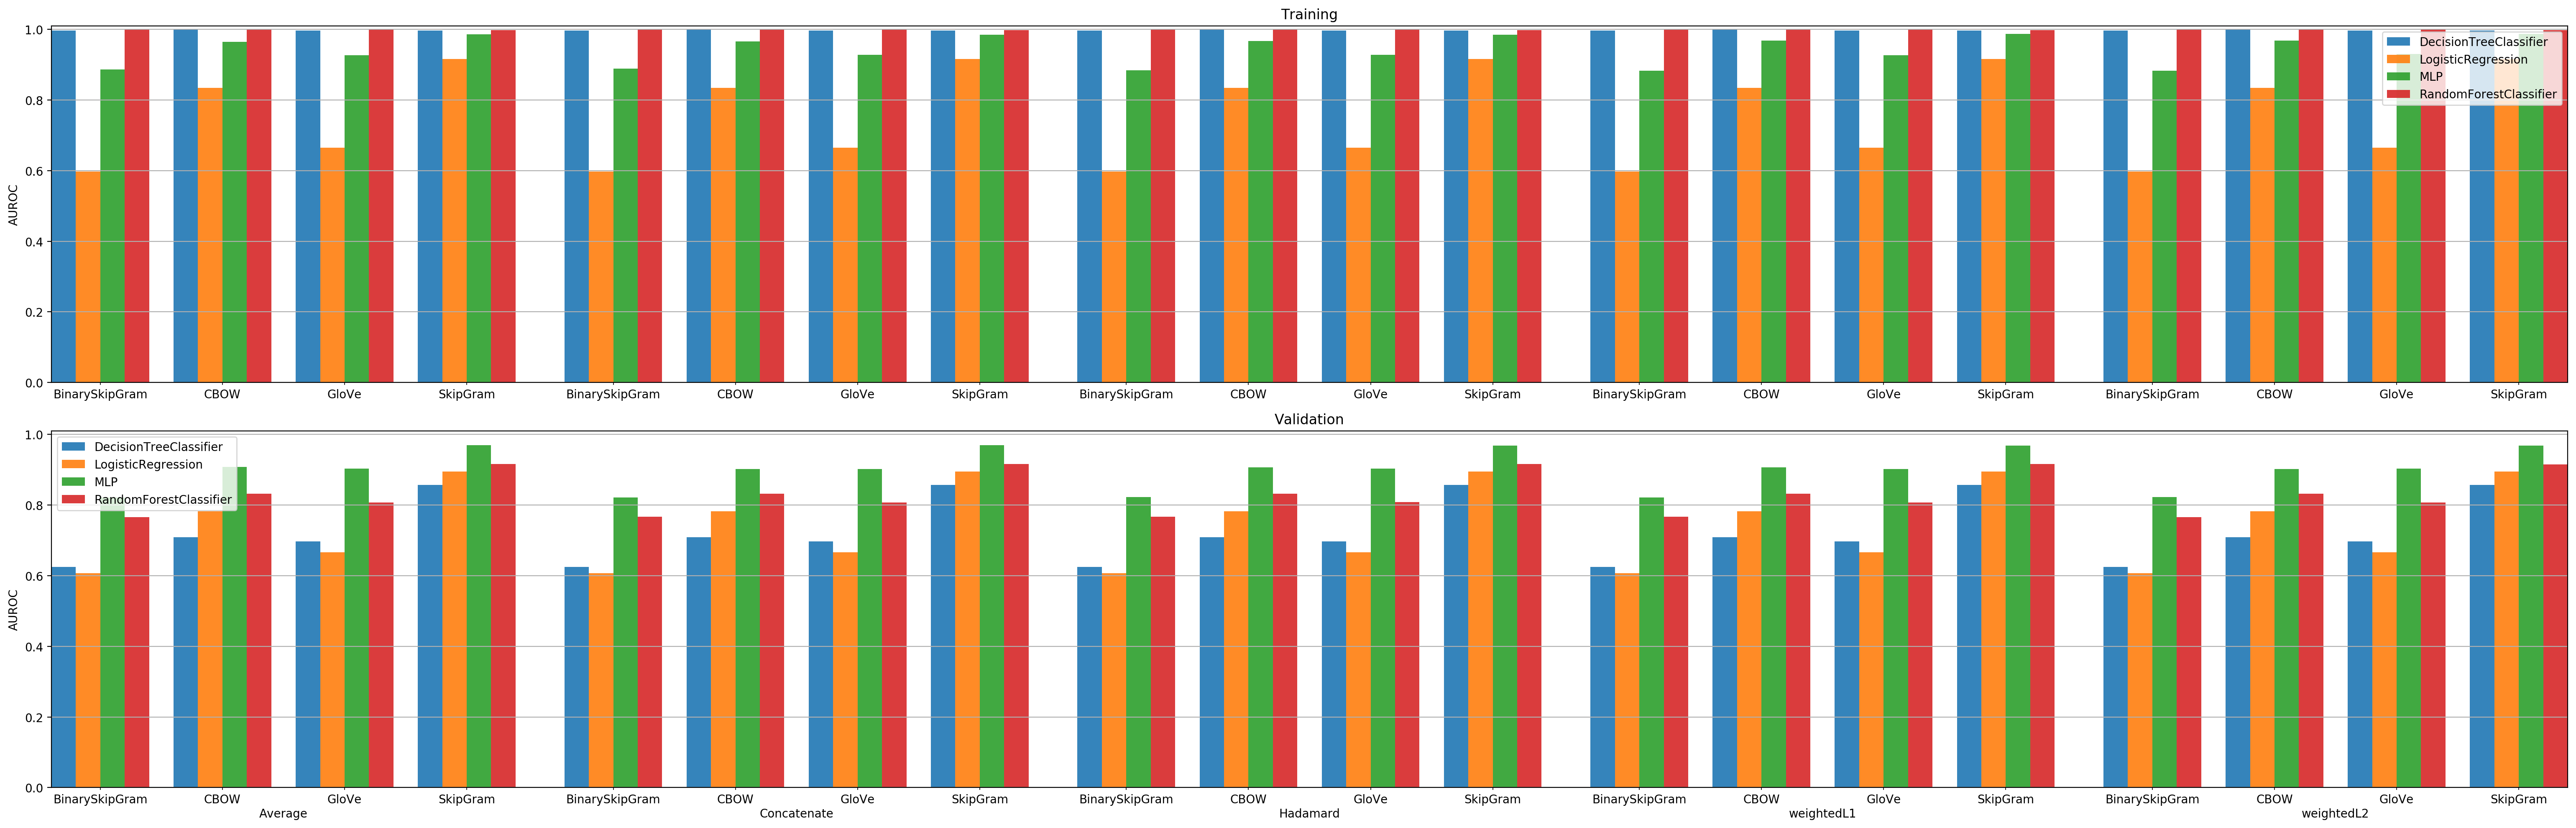

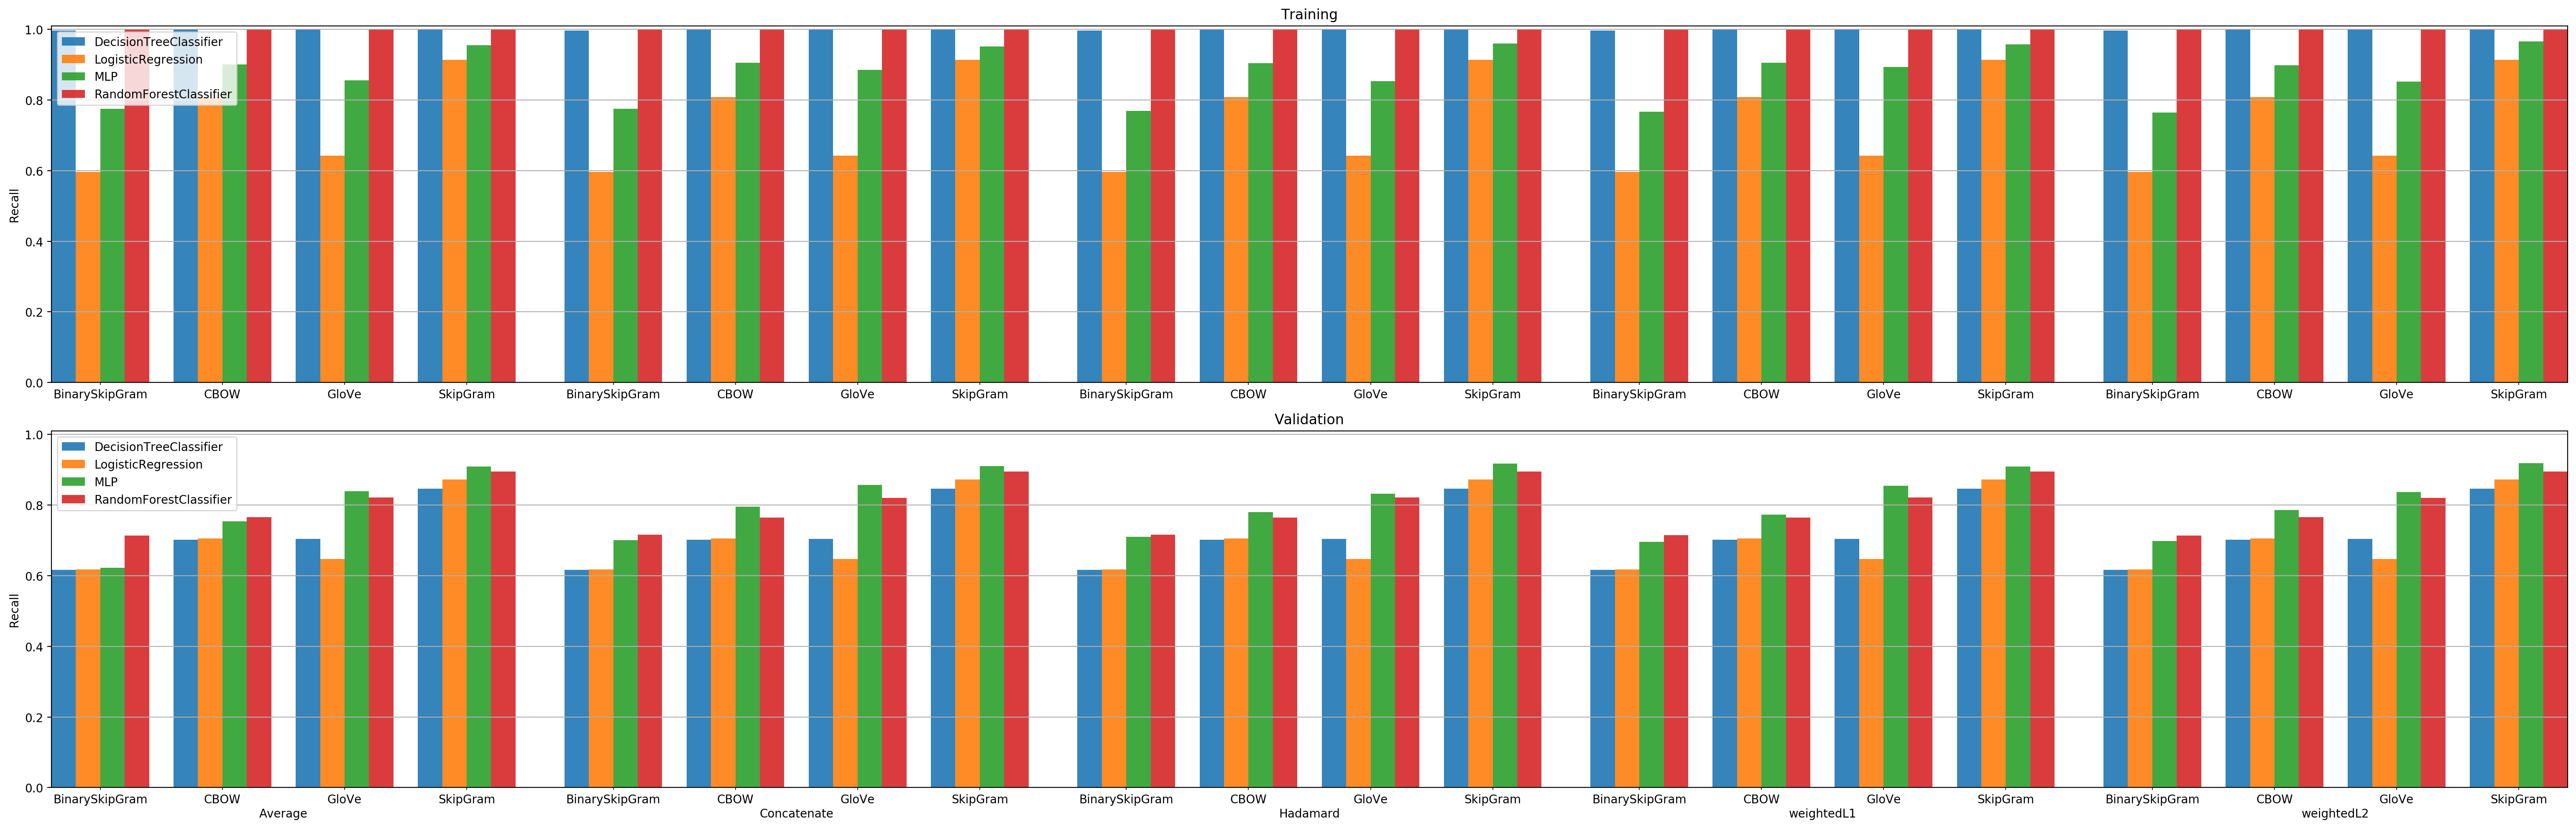

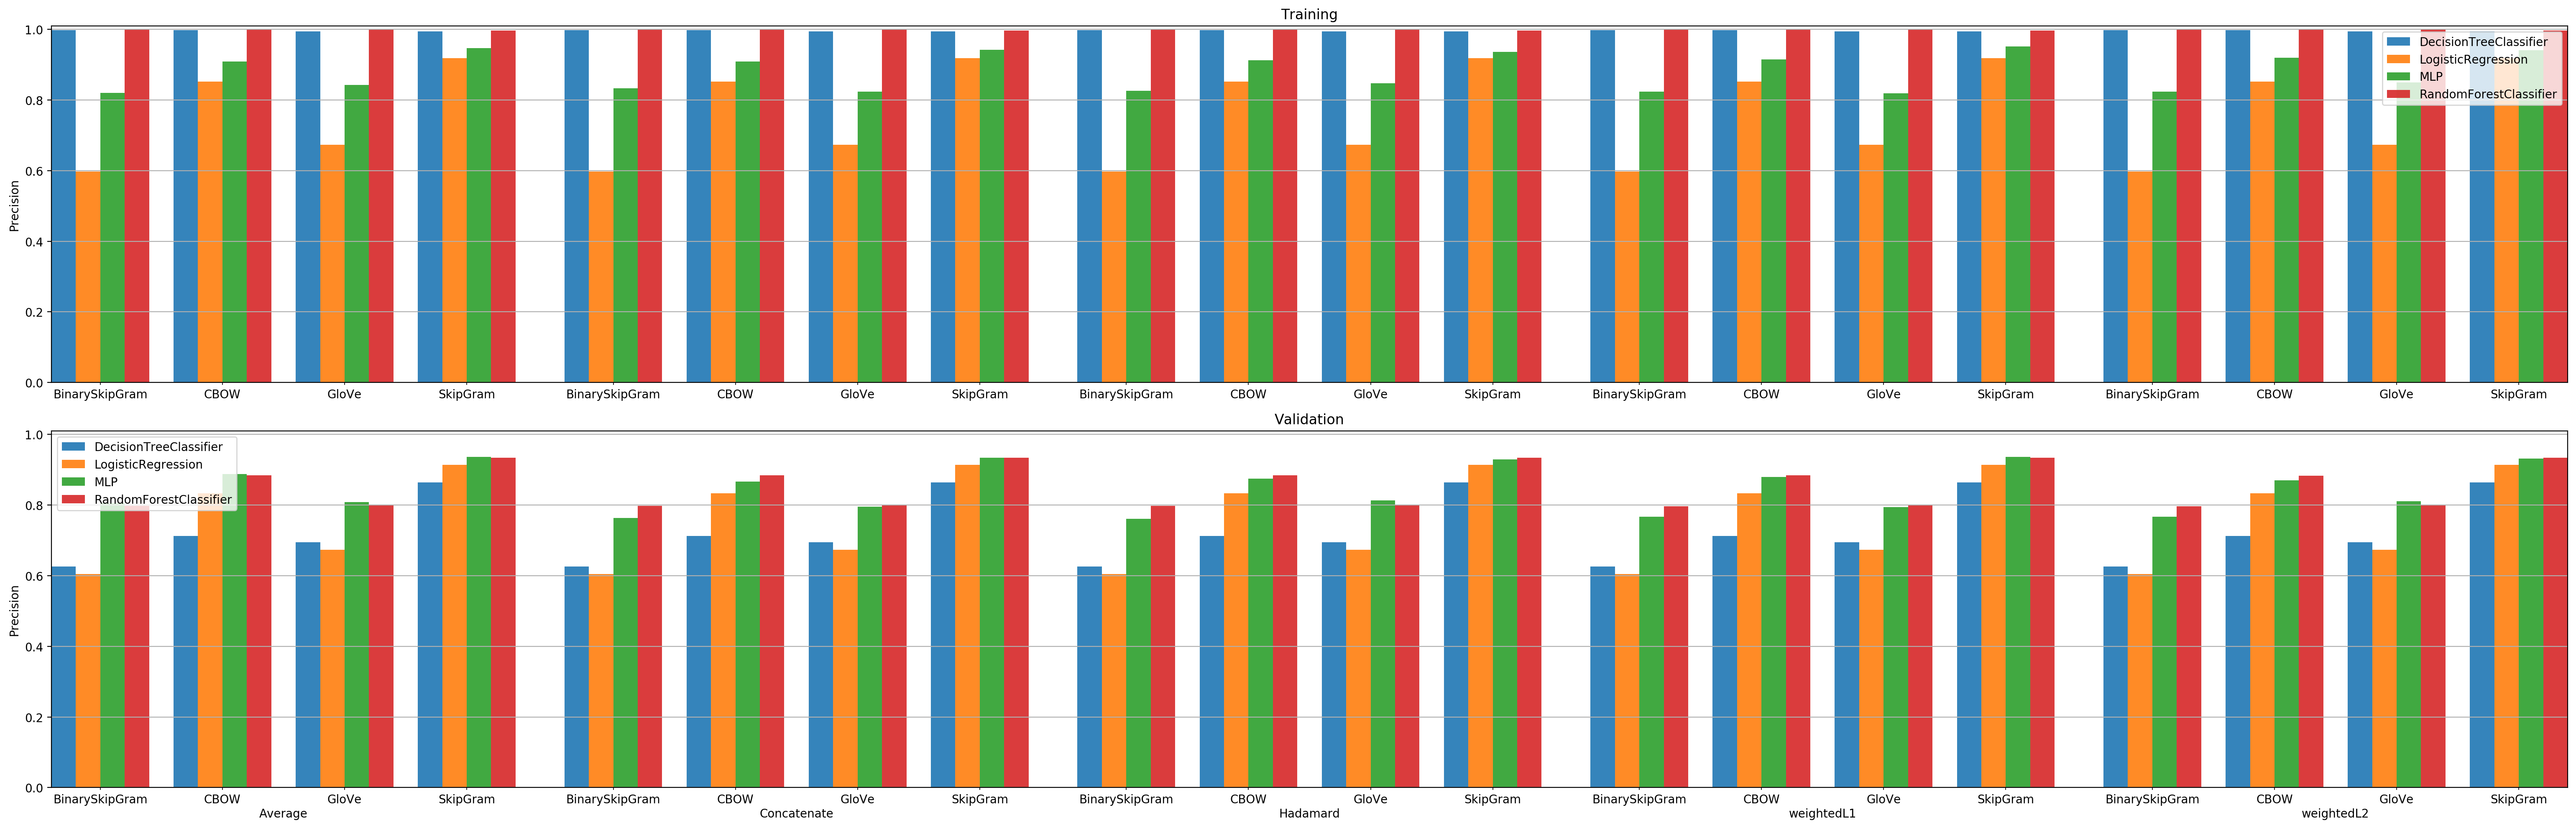

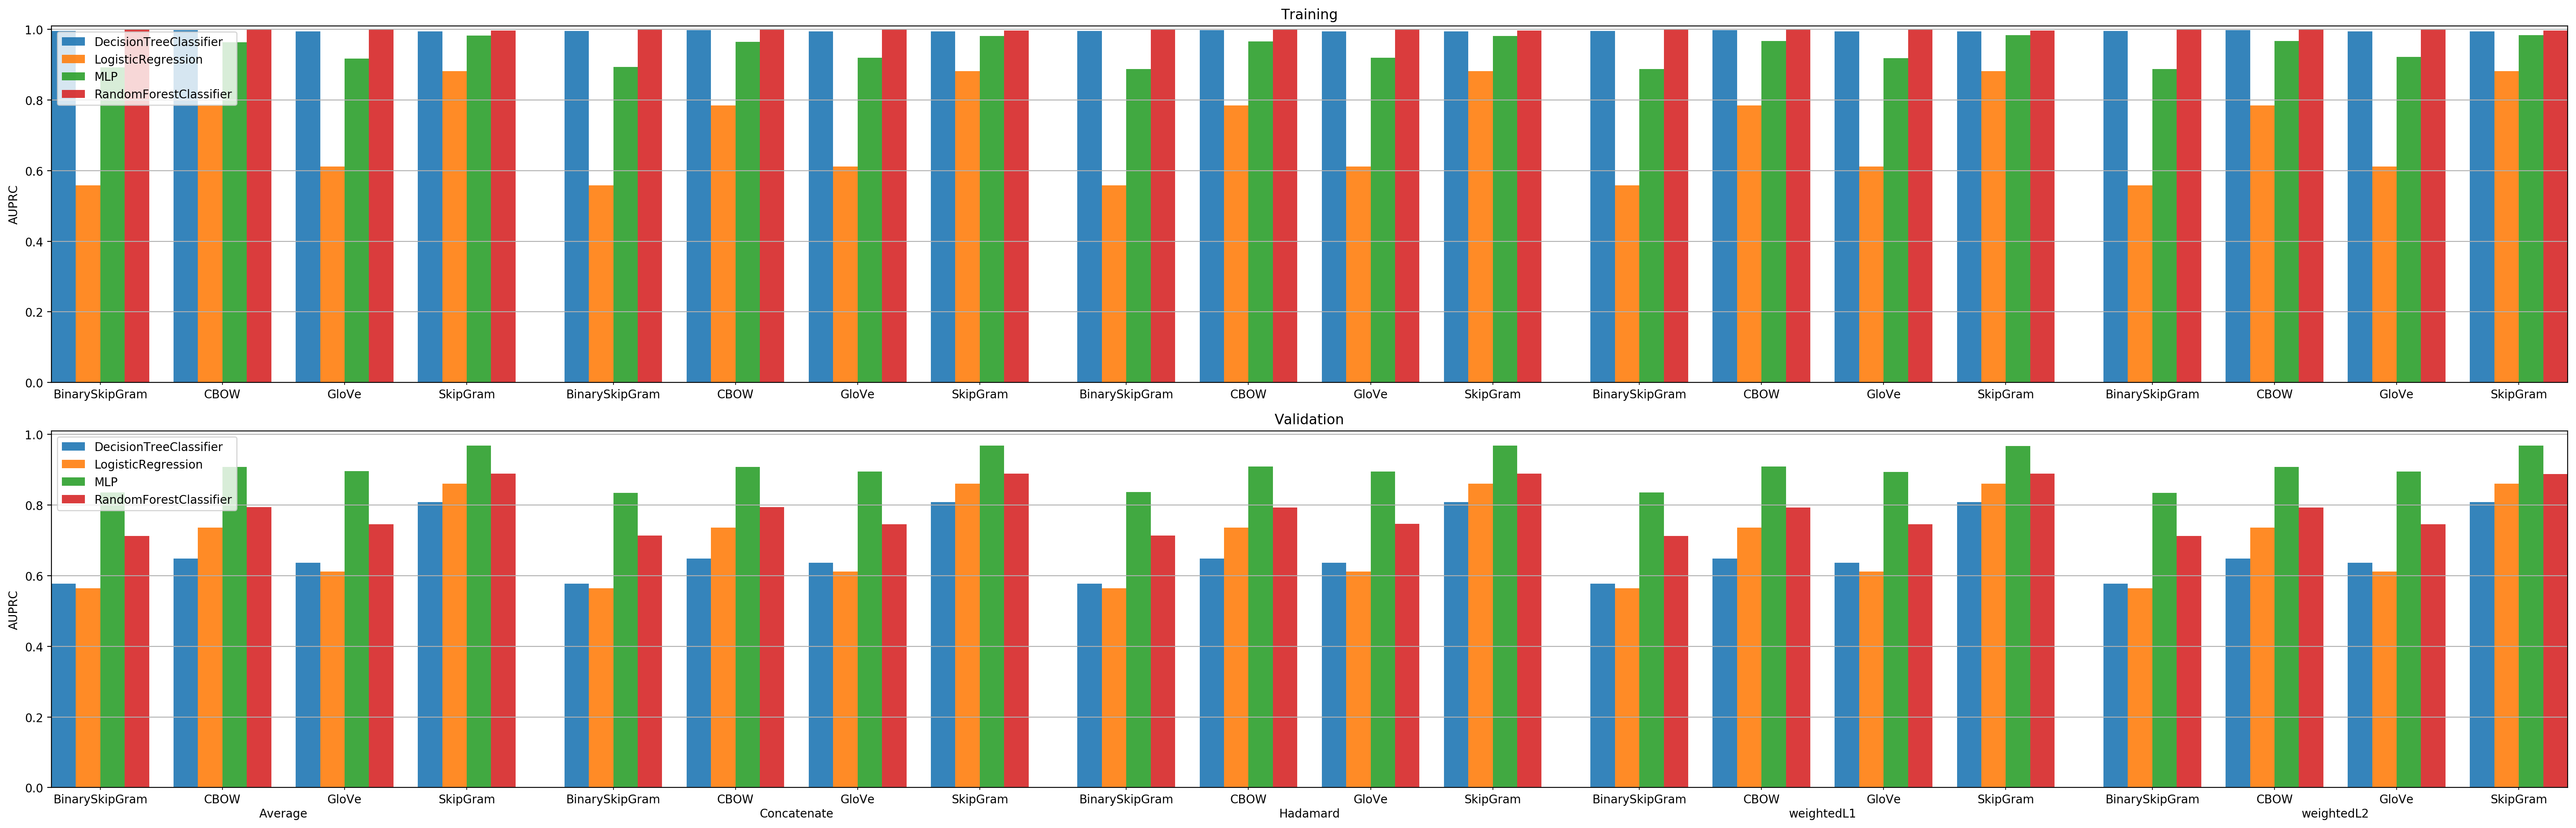

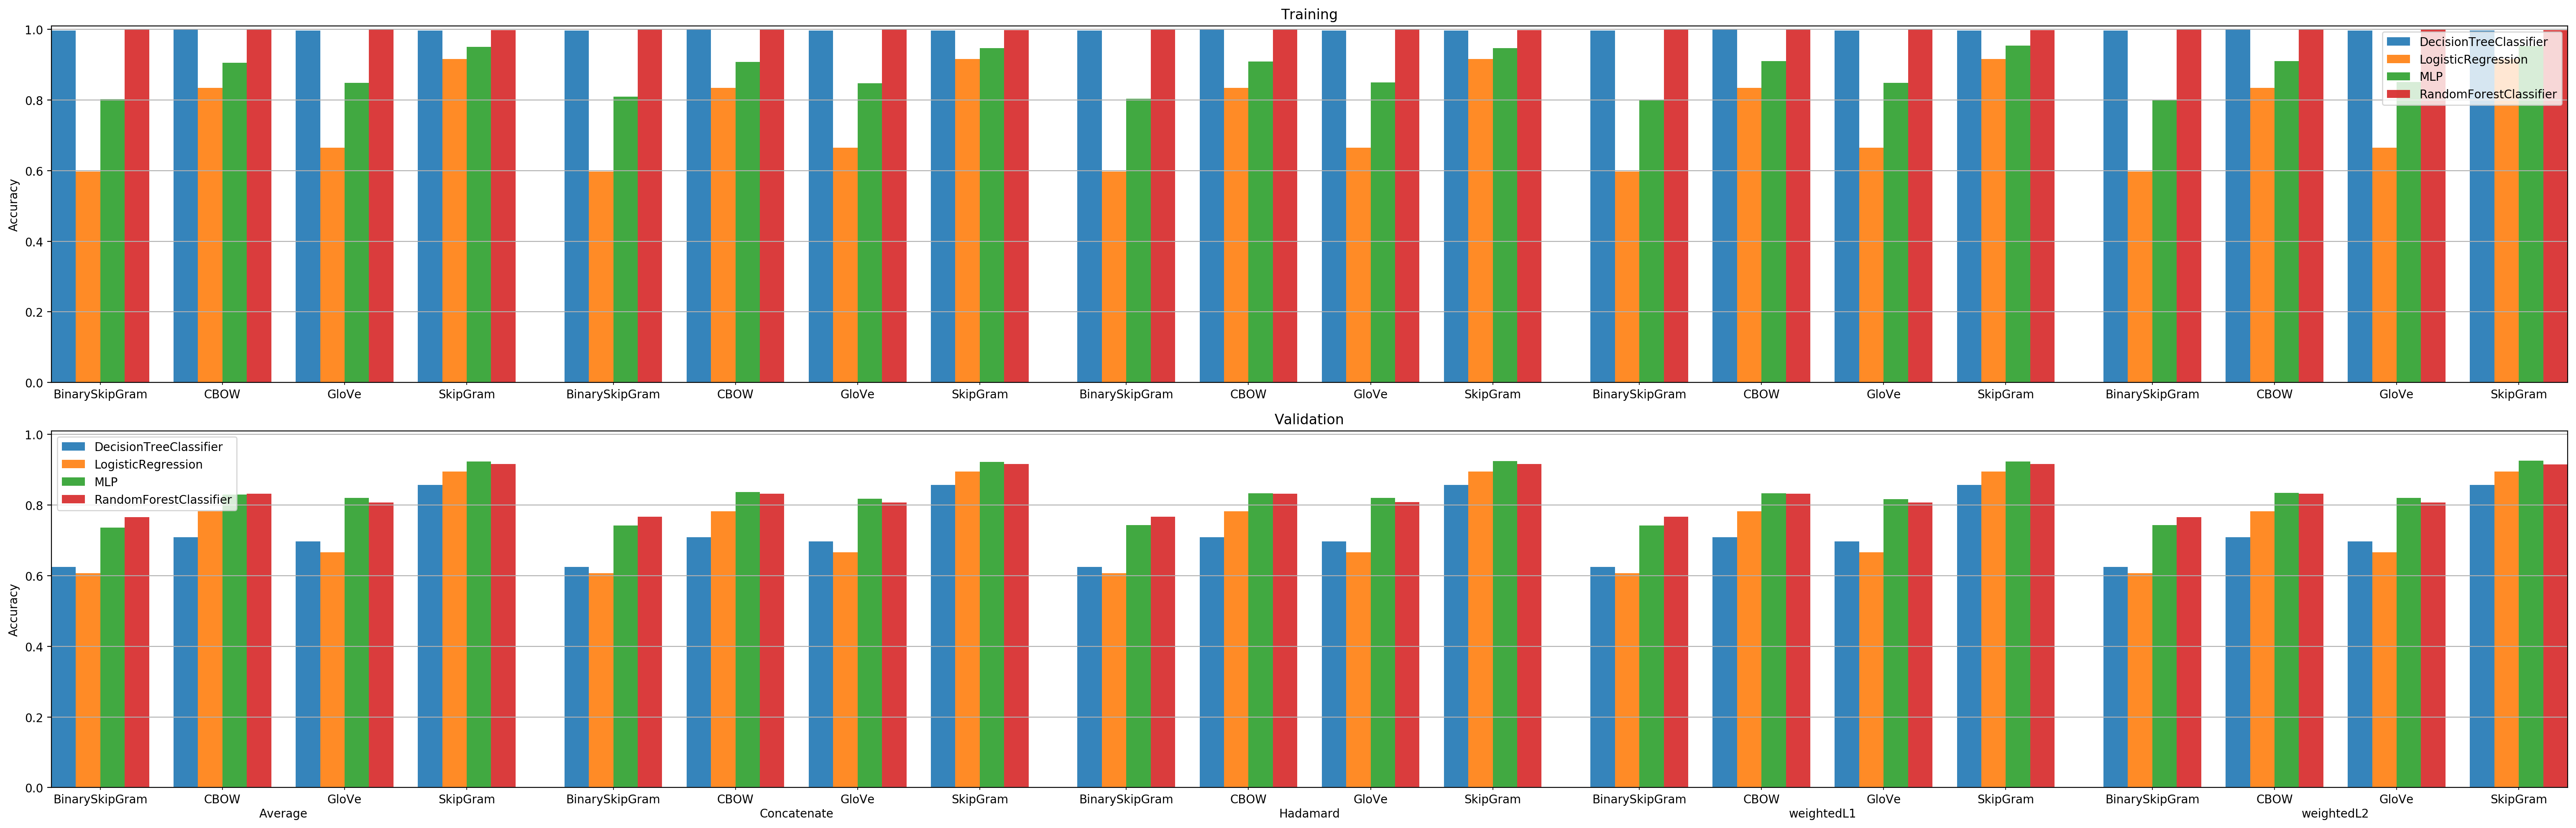

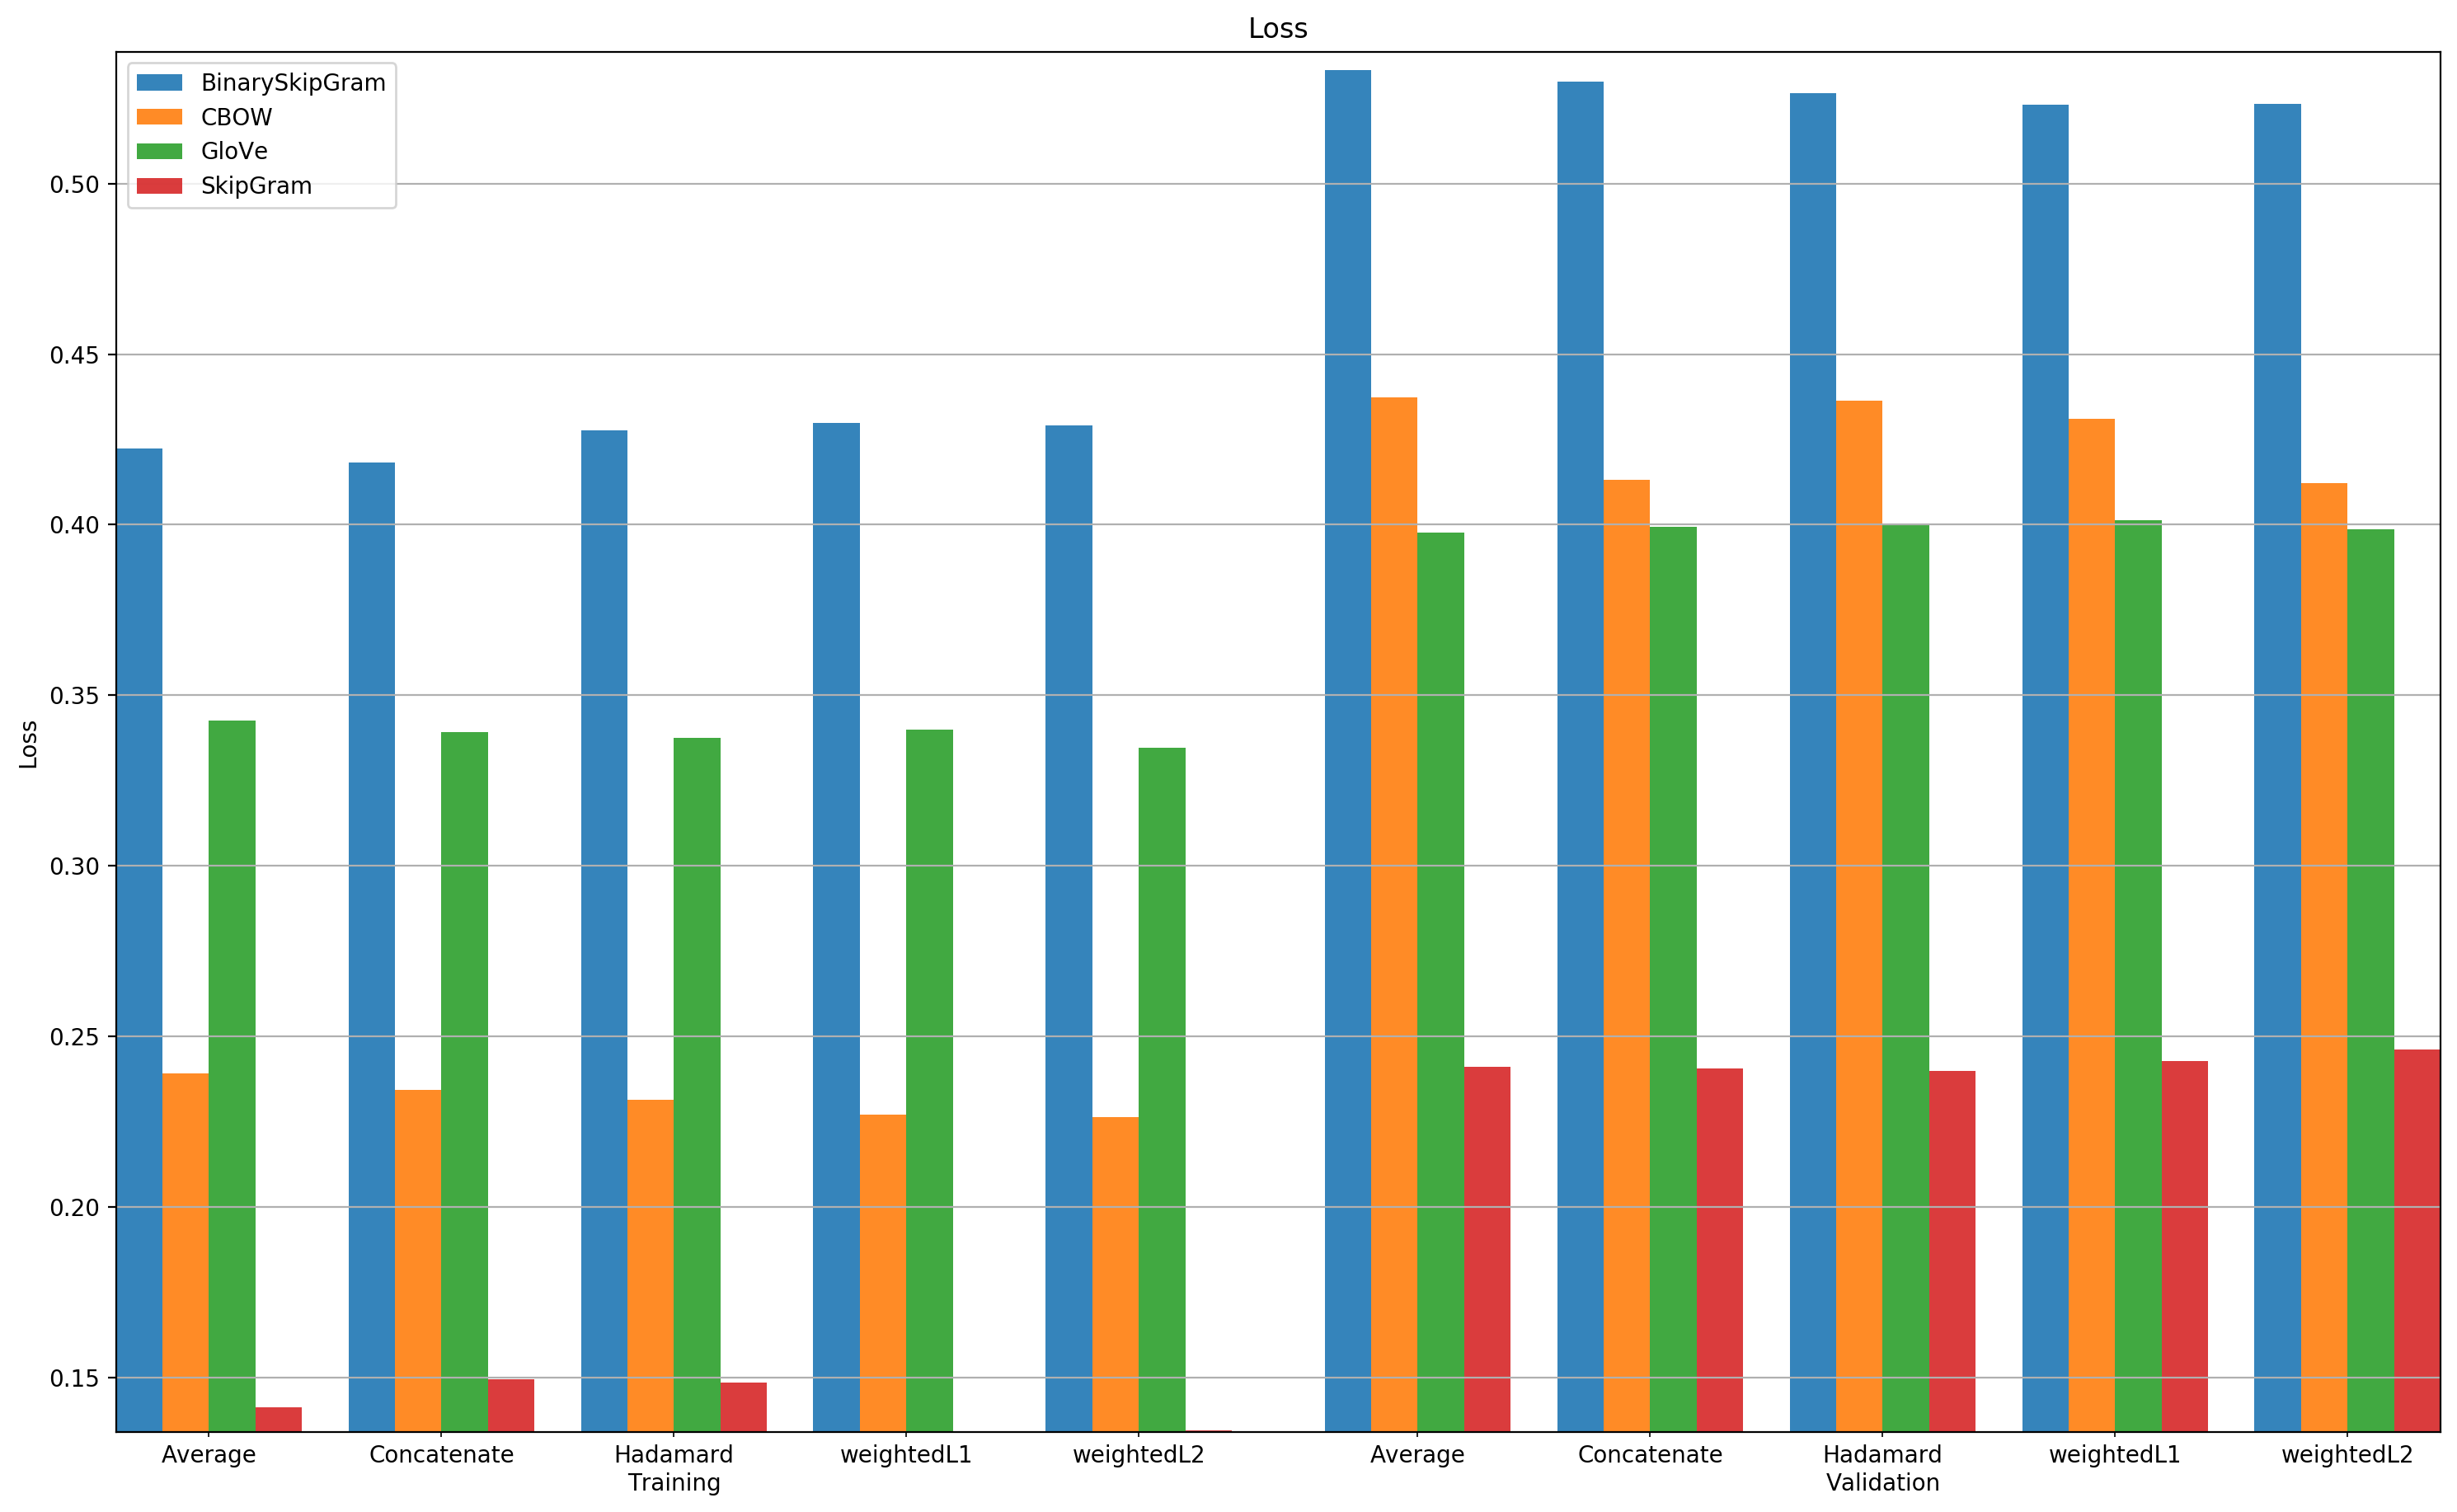

In [53]:
# show_standard_deviation is False because there is only one holdout!
barplots(
    all_reports,
    ["run", "method", "embedding_model", "model"],
    show_standard_deviation=False,
    height=5,
    subplots=True,
    plots_per_row=1
)

for barplot_path in glob("barplots/*"):
    display(Image.open(barplot_path))